In [1]:
# パッケージのimport
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import gym

In [2]:
# 動画の描画

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')  # 動画のファイル名と保存
    display(display_animation(anim, default_mode='loop'))

In [3]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
GAMMA = 0.99  # 時間割引率
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数

In [5]:
# 経験を保存するメモリクラスを定義

class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

In [6]:
# エージェントが持つ脳となるクラスです、DQNを実行します
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 64
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action

In [7]:
# CartPoleのエージェントクラス＝棒付き台車そのもの


class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)

In [8]:
# CartPoleを実行する環境のクラス


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

        
    def run(self):
        '''実行'''
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数
        finished_step=[]
        reward_means=[]
        goal_average_reward=0.975
        num_consecutive_iterations = 100 
        total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納

        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            episode_reward = 0 

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(torch.FloatTensor)  # NumPy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))
                   

                action = self.agent.get_action(state, episode)  # 行動を求める

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(action.item())  # rewardとinfoは使わないので_にする
                
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    if step < 199:
                        reward = torch.FloatTensor([-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        episode_reward+=reward.numpy()
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        episode_reward+=reward.numpy()
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    episode_reward+=reward.numpy()
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                
                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward)) 
                    print('{0} Episode: Finished after {1} time steps  Episode Reward:{2}/Mean:{3}'.format(
                        episode+1, step + 1,episode_reward,total_reward_vec.mean()))
                    finished_step.append(step+1)
                    reward_means.append(total_reward_vec.mean())
                    #print(total_reward_vec)
                    break

            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break

          
            if  (total_reward_vec.mean() >= goal_average_reward) or ((episode+1)==NUM_EPISODES-1):
                episode_final = True  # 次の試行を描画を行う最終試行とする
                print('学習完了')
                
                #グラフの表示（2スケールで出力）
                x=np.linspace(1,episode+1,episode+1)
                y1=finished_step
                y2=reward_means
                width1=((episode+1)/500)*6.4 #小スケールでの出力サイズ
                width2=((episode+1)/150)*6.4 #大スケールでの出力サイズ
                
                fig1=plt.figure(figsize=(width1,4.8)) #達成ステップ数のグラフ画像
                ax1=fig1.add_subplot(111)
                ax1.plot(x,y1,lw=0.6)
                ax1.set_xlabel('episode')
                ax1.set_ylabel('max step')
                ax1.set_xlim(1,episode+1)
                ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
                plt.grid(b=True, which='major',color='#999999', linestyle='-', alpha=0.4)

                fig2=plt.figure(figsize=(width1,4.8)) #平均報酬のグラフ画像
                ax2=fig2.add_subplot(111)
                ax2.plot(x,y2,lw=0.6)
                ax2.set_xlabel('episode')
                ax2.set_ylabel('reward mean')
                ax2.set_xlim(1,episode+1)
                ax2.set_ylim(-1,1)
                ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
                plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.4)
                
                fig3=plt.figure(figsize=(width2,4.8)) #達成ステップ数のグラフ画像
                ax3=fig3.add_subplot(111)
                ax3.plot(x,y1,lw=0.6)
                ax3.set_xlabel('episode')
                ax3.set_ylabel('max step')
                ax3.set_xlim(1,episode+1)
                ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
                plt.grid(b=True, which='major',color='#999999', linestyle='-', alpha=0.4)
                
                fig4=plt.figure(figsize=(width2,4.8)) #平均報酬のグラフ画像
                ax4=fig4.add_subplot(111)
                ax4.plot(x,y2,lw=0.6)
                ax4.set_xlabel('episode')
                ax4.set_ylabel('reward mean')
                ax4.set_xlim(1,episode+1)
                ax4.set_ylim(-1,1)
                ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
                plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.4)

C:\Users\hirot\Anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
1 Episode: Finished after 11 time steps  Episode Reward:[-1.]/Mean:-0.01
2 Episode: Finished after 11 time steps  Episode Reward:[-1.]/Mean:-0.02
3 Episode: Finished after 11 time steps  Episode Reward:[-1.]/Mean:-0.03
4 Episode: Finished after 10 time steps  Episode Reward:[-1.]/Mean:-0.04
5 Episode: Finished after 10 time steps  Episode Reward:[-1.]/Mean:-0.05
6 Episode: Finished after 10 time steps  Episode Reward:[-1.]/Mean:-0.06
7 Episode: Finished after 9 time steps  Episode Reward:[-1.]/Mean:-0.07
8 Episode: Finished after 10 time steps  Episode Reward:[-1.]/Mean:-0.08
9 Episode: Finished after 9 time steps  Episode Reward:[-1.]/Mean:-0.09
10 Episode: Finish

108 Episode: Finished after 90 time steps  Episode Reward:[-1.]/Mean:-1.0
109 Episode: Finished after 83 time steps  Episode Reward:[-1.]/Mean:-1.0
110 Episode: Finished after 90 time steps  Episode Reward:[-1.]/Mean:-1.0
111 Episode: Finished after 56 time steps  Episode Reward:[-1.]/Mean:-1.0
112 Episode: Finished after 88 time steps  Episode Reward:[-1.]/Mean:-1.0
113 Episode: Finished after 100 time steps  Episode Reward:[-1.]/Mean:-1.0
114 Episode: Finished after 120 time steps  Episode Reward:[-1.]/Mean:-1.0
115 Episode: Finished after 125 time steps  Episode Reward:[-1.]/Mean:-1.0
116 Episode: Finished after 136 time steps  Episode Reward:[-1.]/Mean:-1.0
117 Episode: Finished after 160 time steps  Episode Reward:[-1.]/Mean:-1.0
118 Episode: Finished after 106 time steps  Episode Reward:[-1.]/Mean:-1.0
119 Episode: Finished after 129 time steps  Episode Reward:[-1.]/Mean:-1.0
120 Episode: Finished after 123 time steps  Episode Reward:[-1.]/Mean:-1.0
121 Episode: Finished after 10

217 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.64
218 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.62
219 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.6
220 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.58
221 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.56
222 Episode: Finished after 181 time steps  Episode Reward:[-1.]/Mean:-0.56
223 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.54
224 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.52
225 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.5
226 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.48
227 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.46
228 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.44
229 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:-0.42
230 Episode: Finished afte

328 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:0.96
329 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:0.96
330 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:0.96
331 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:0.98
学習完了
332 Episode: Finished after 200 time steps  Episode Reward:[1.]/Mean:0.98



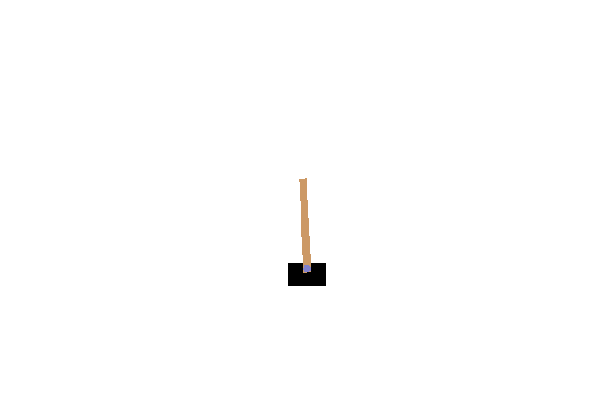
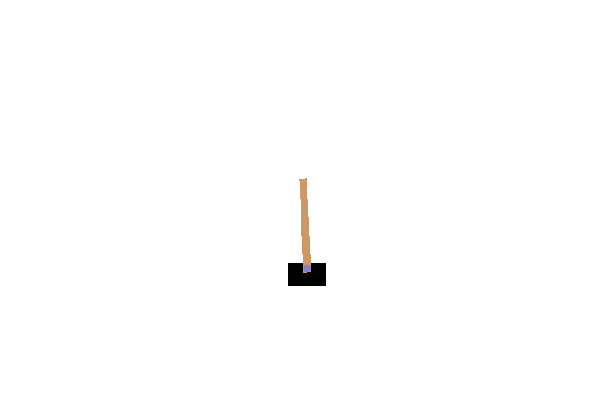
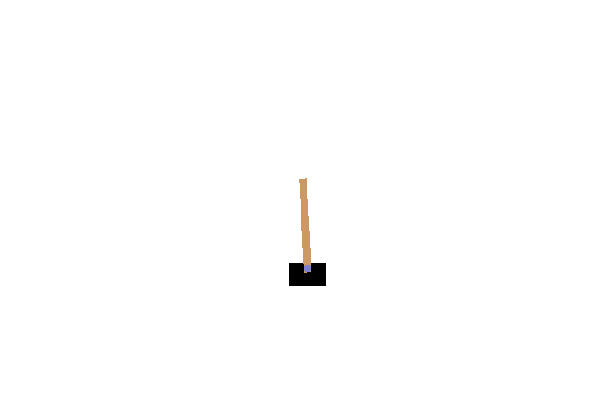
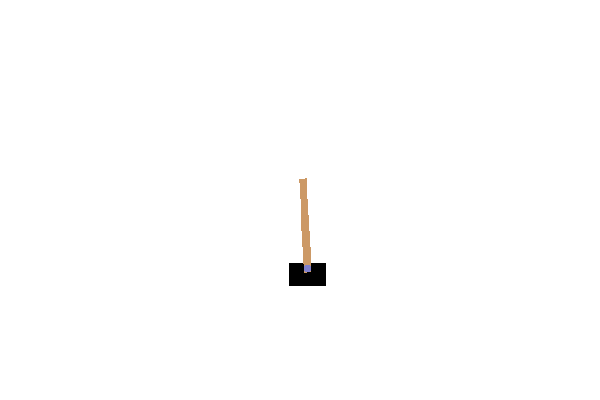
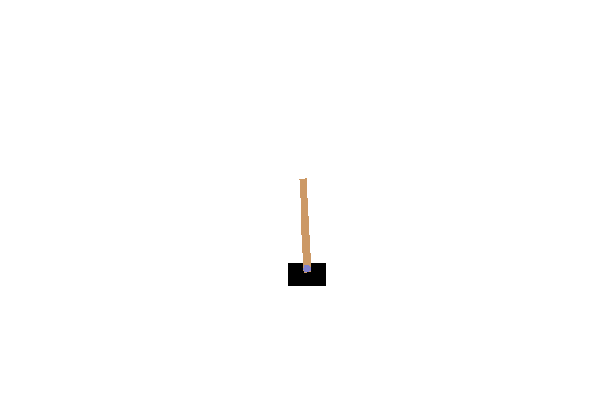
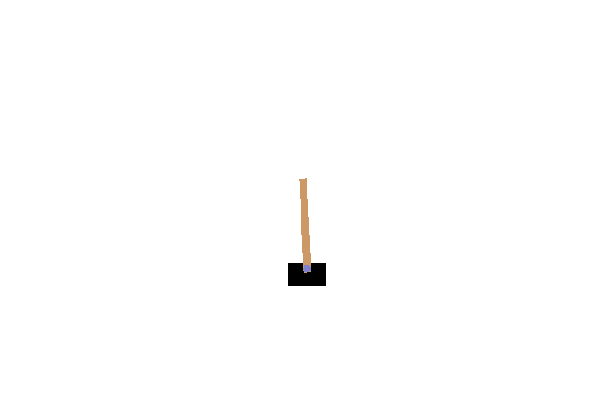
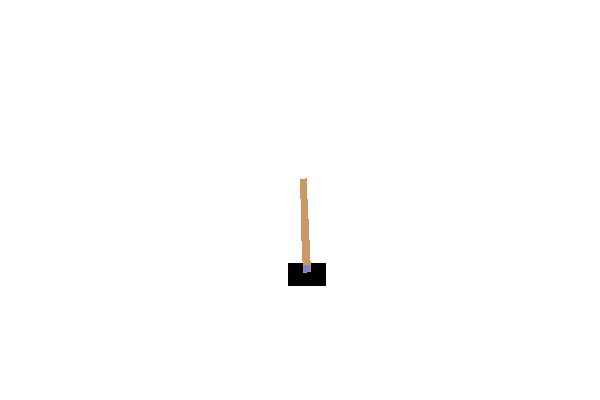
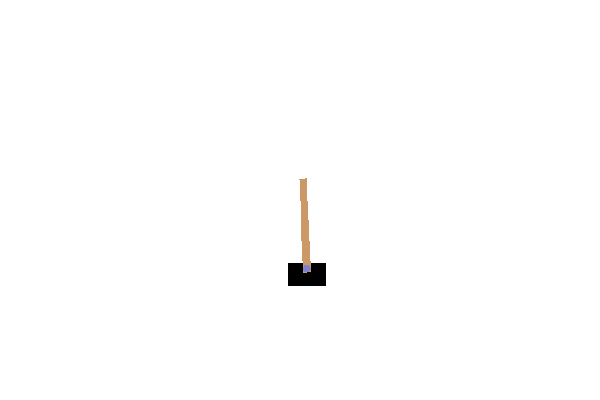
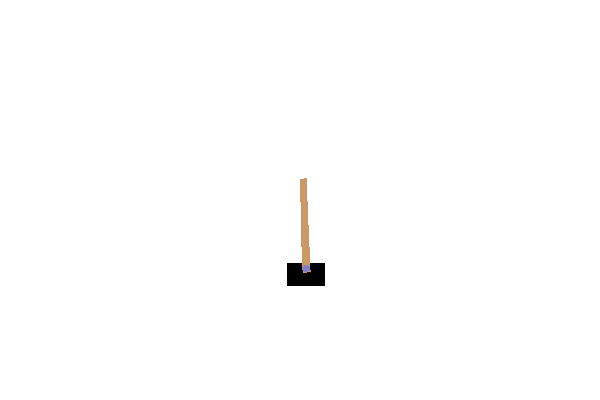
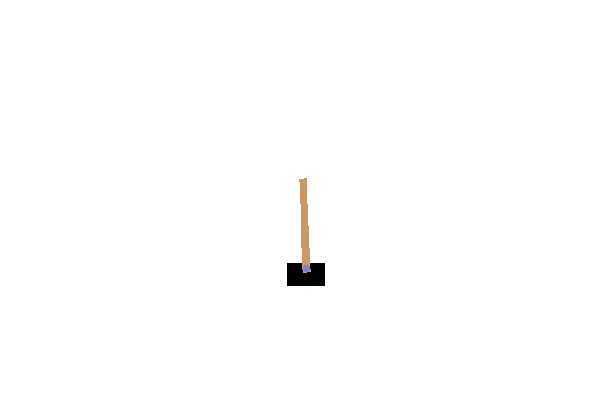
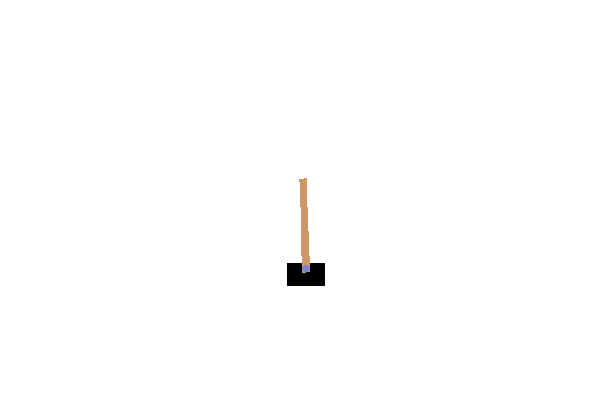
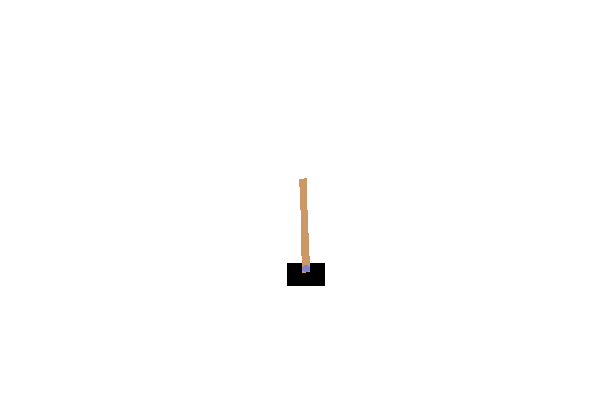
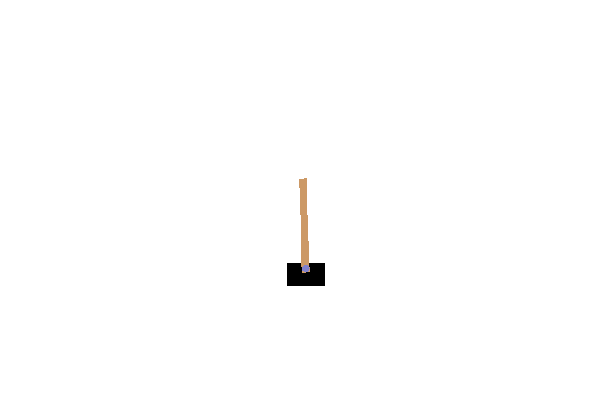
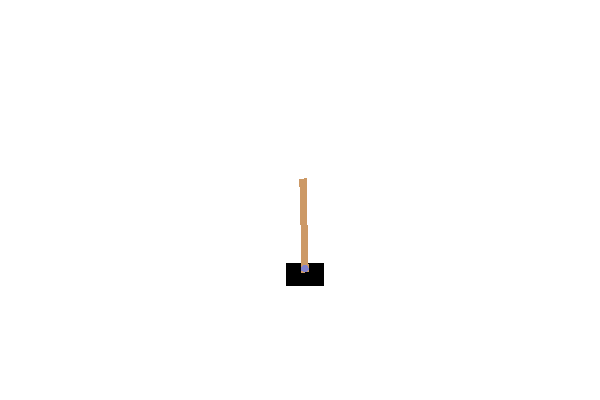
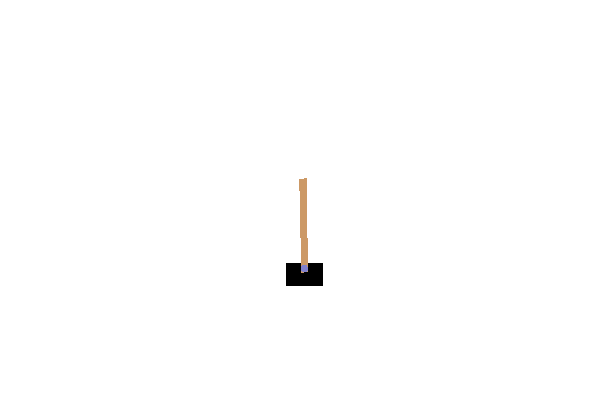
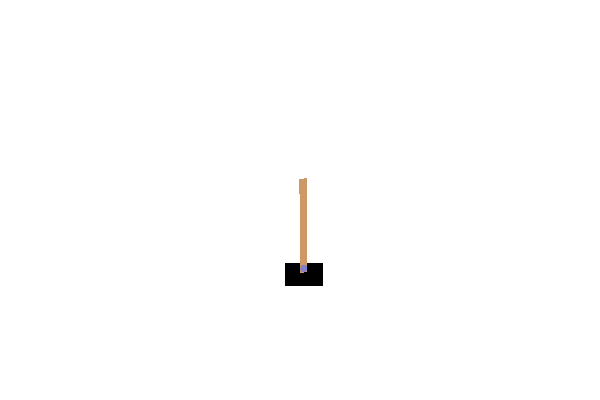
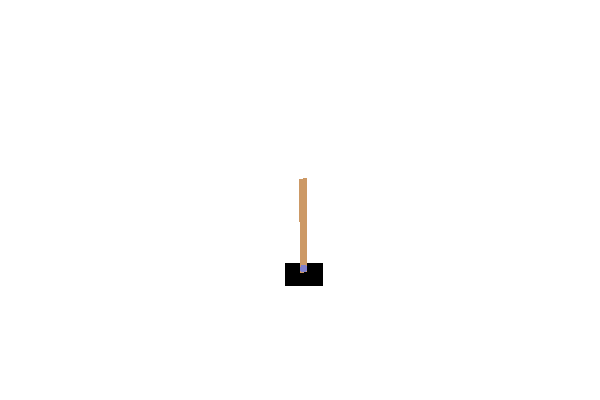
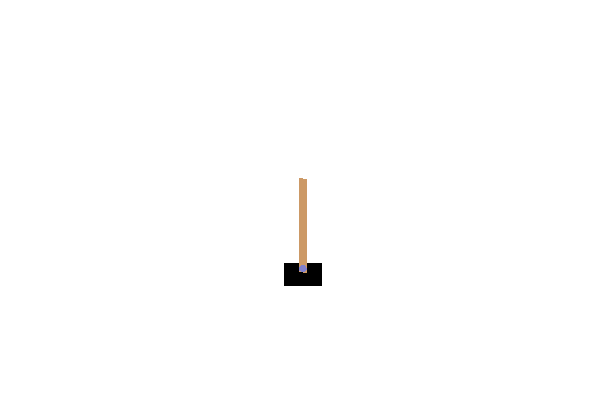
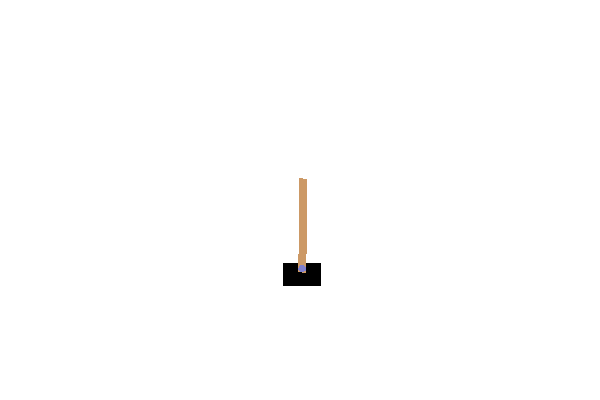
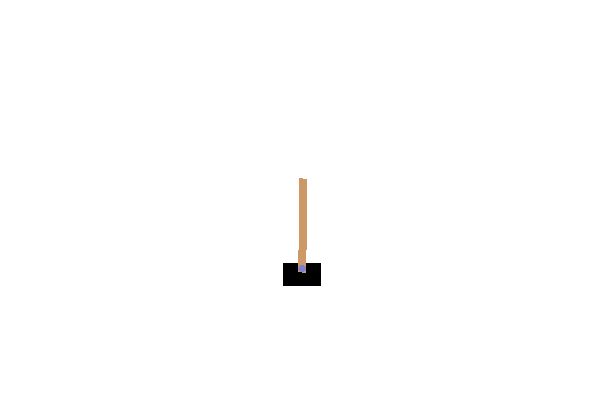
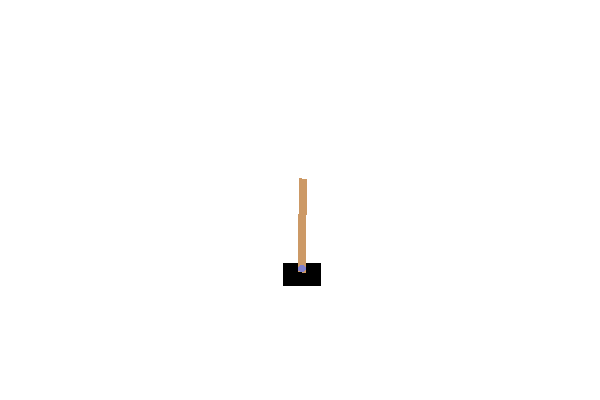
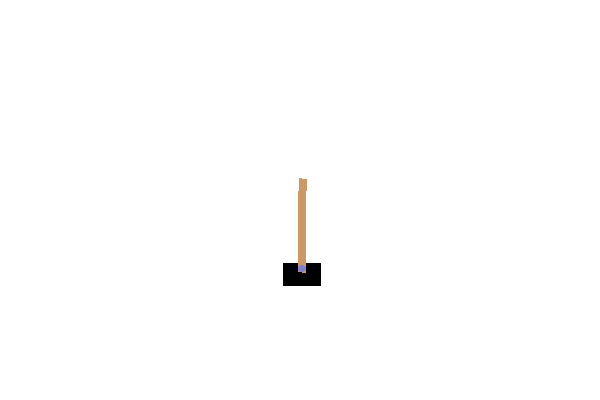
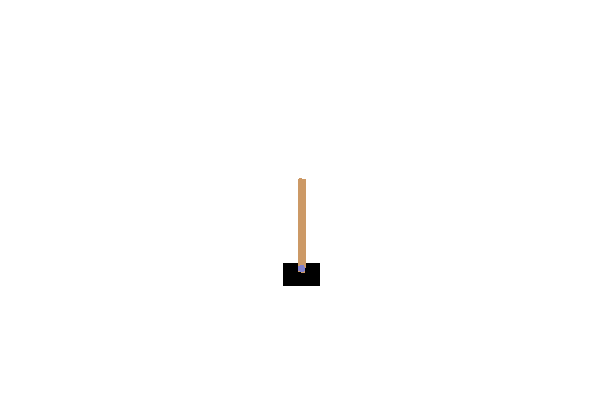
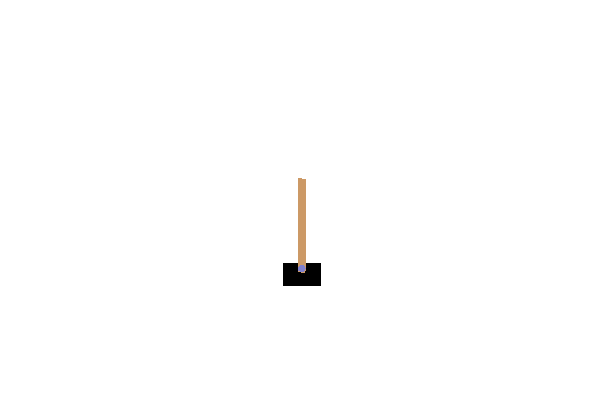
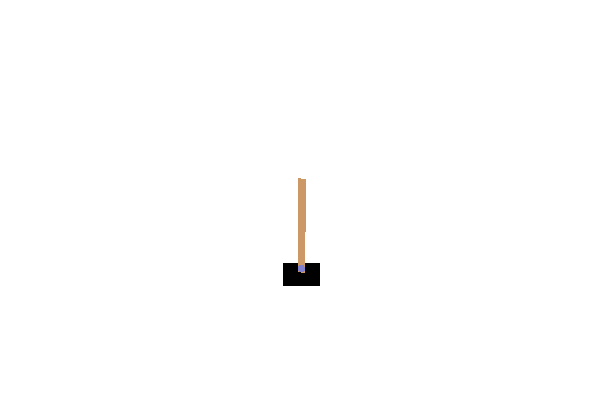
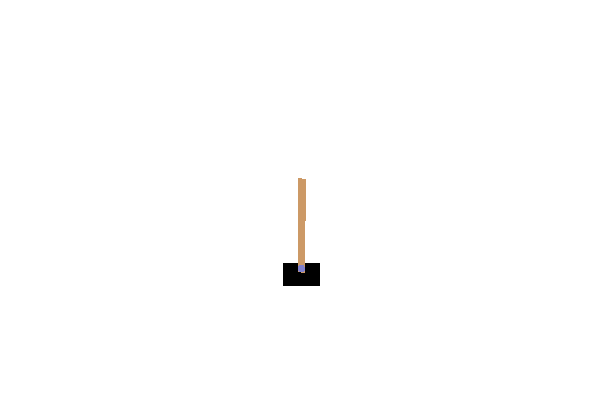
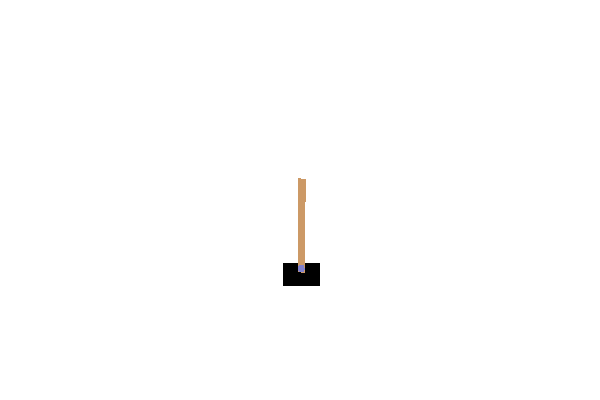
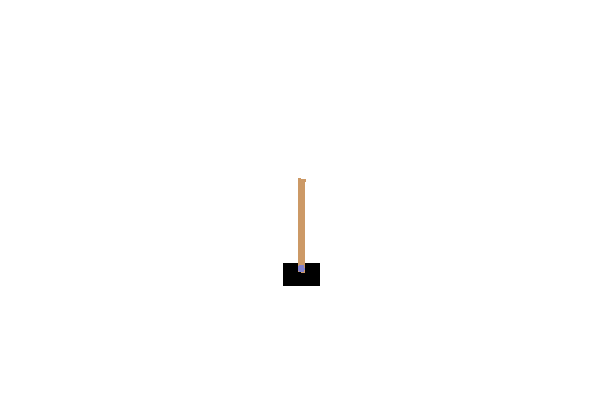
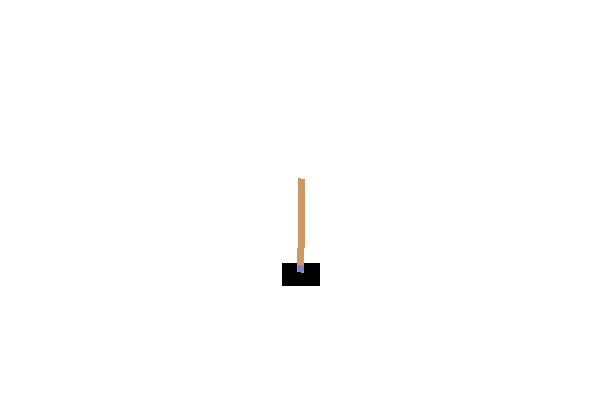
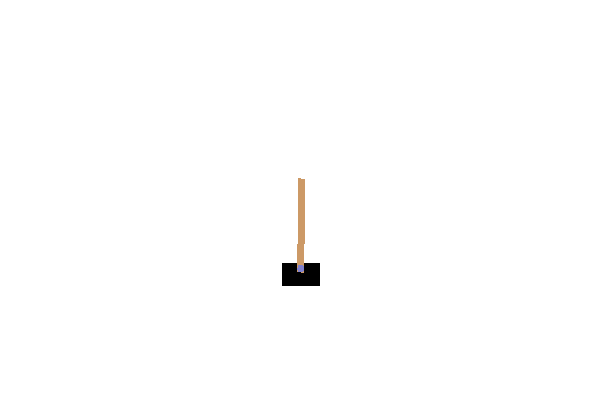
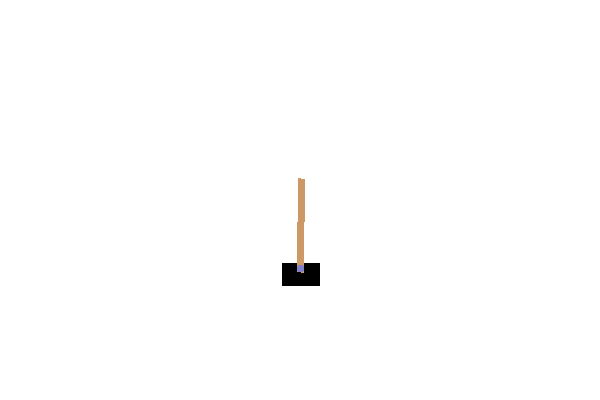
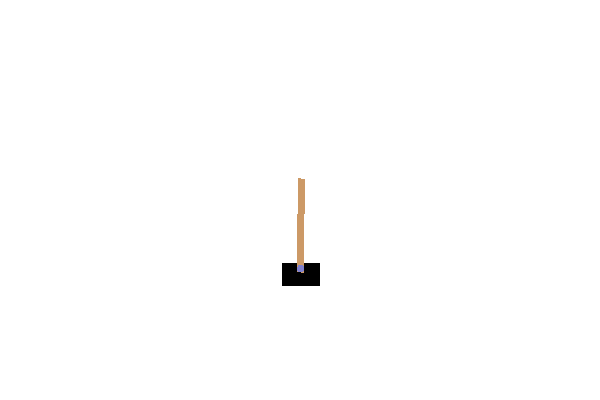
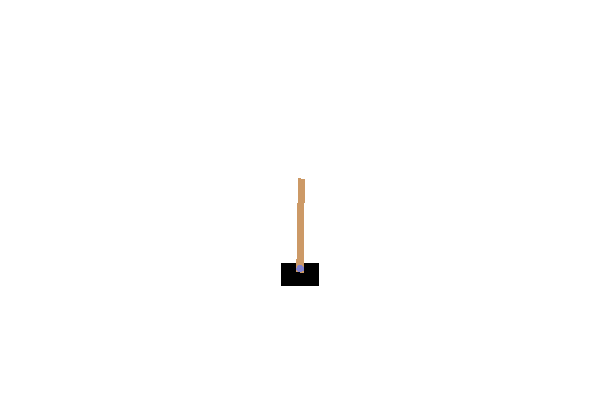
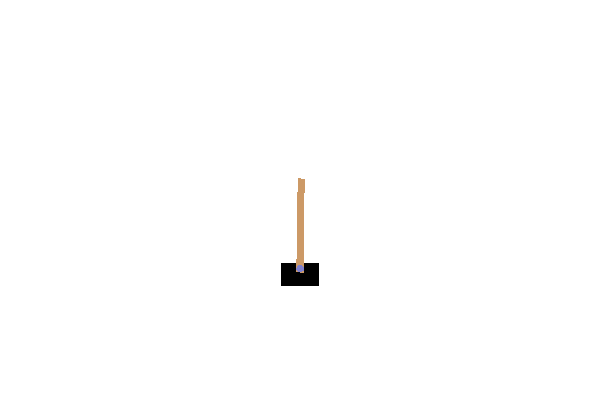
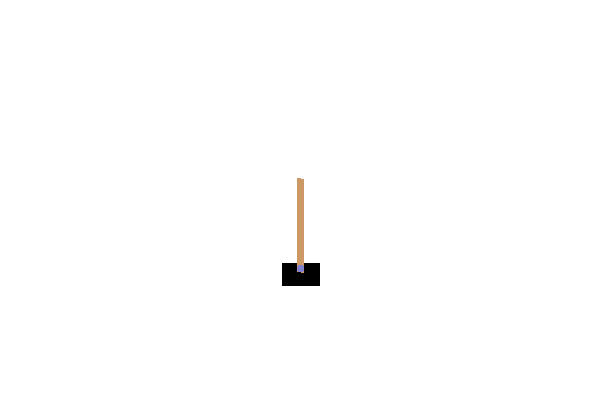
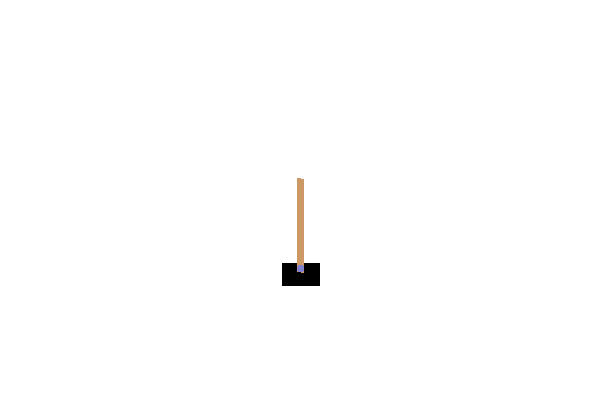
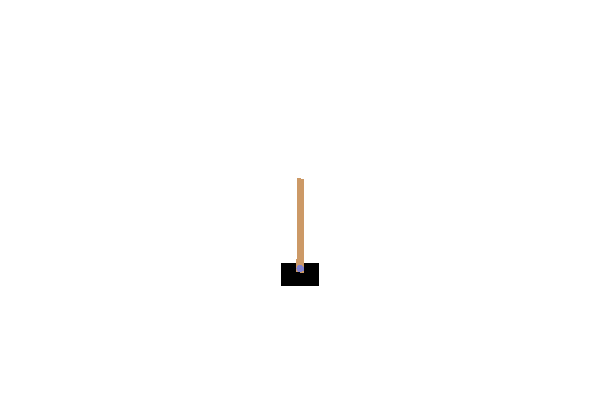
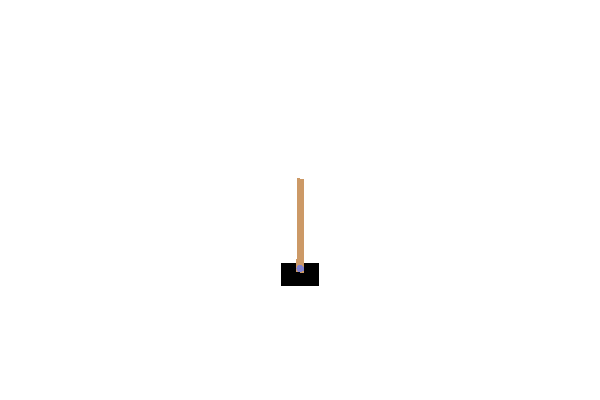
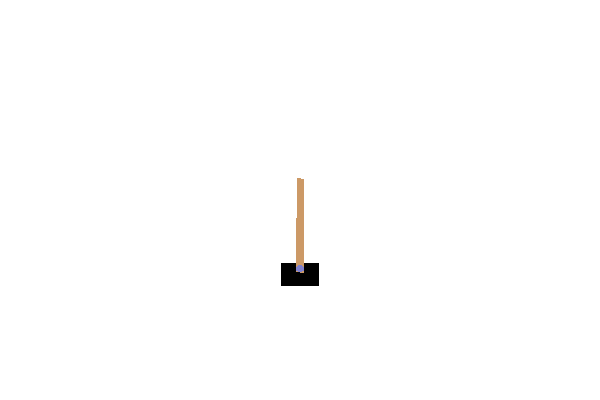
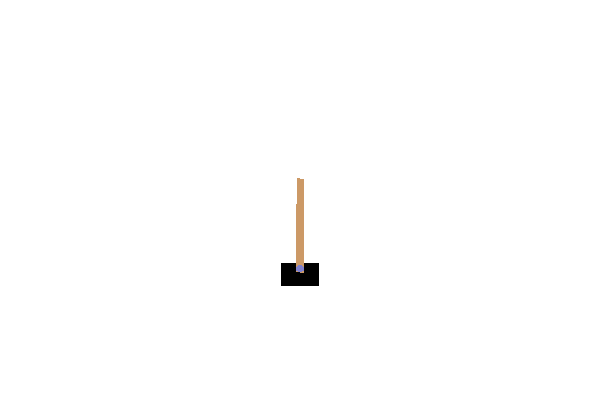
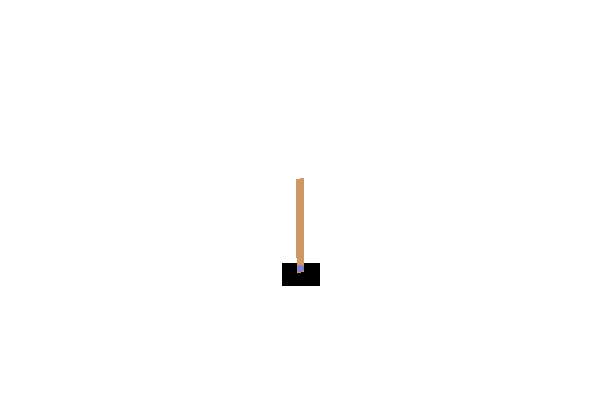
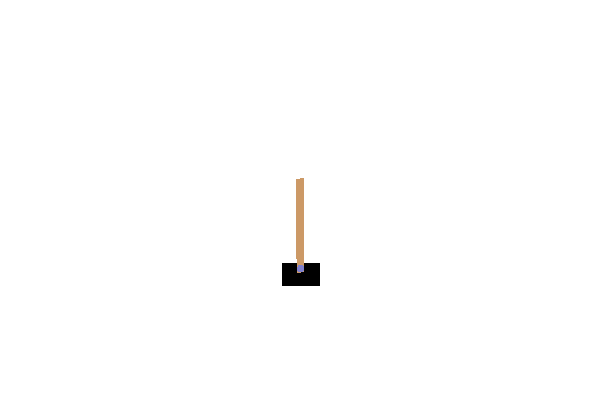
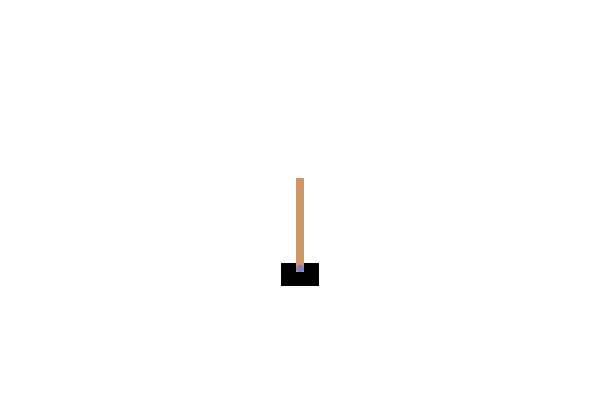
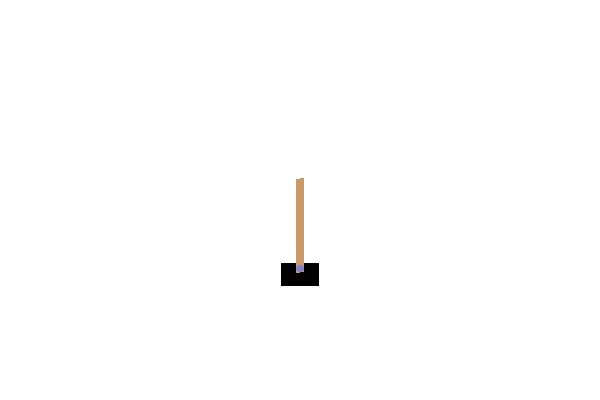
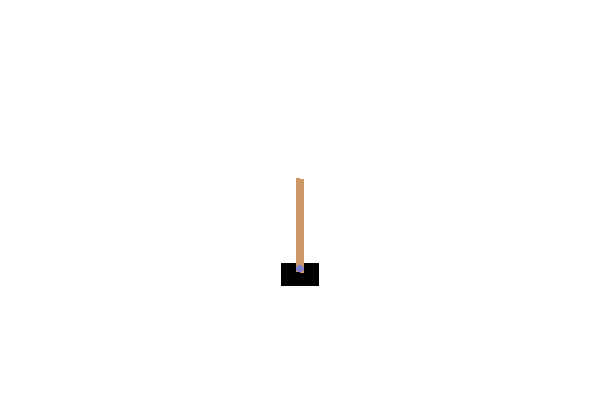
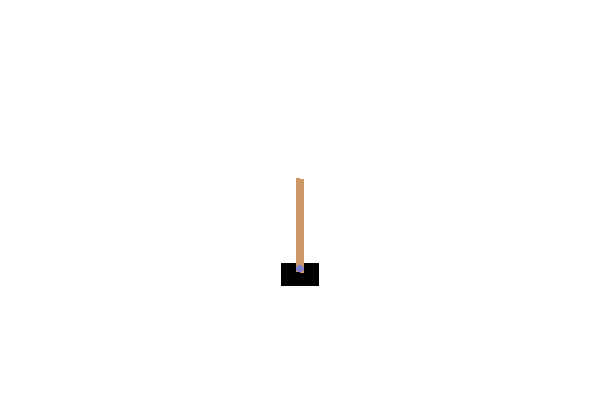
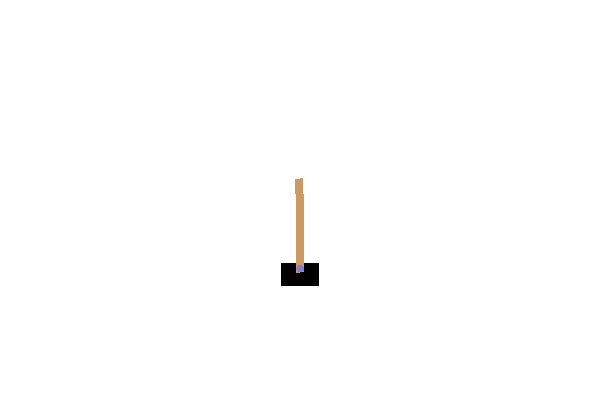
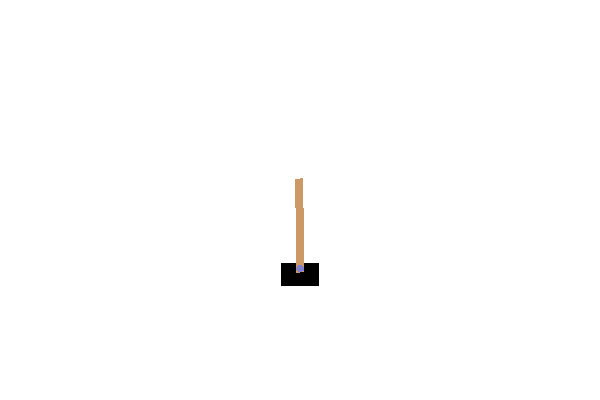
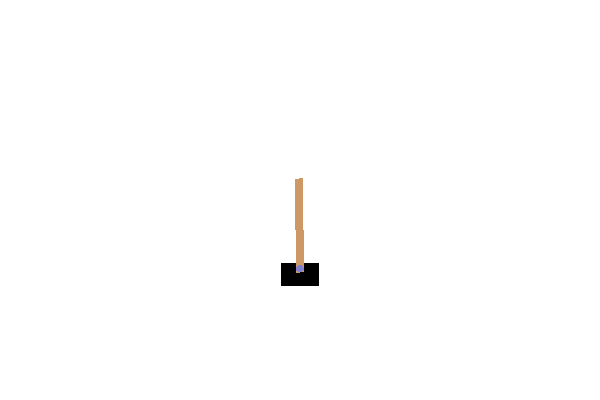
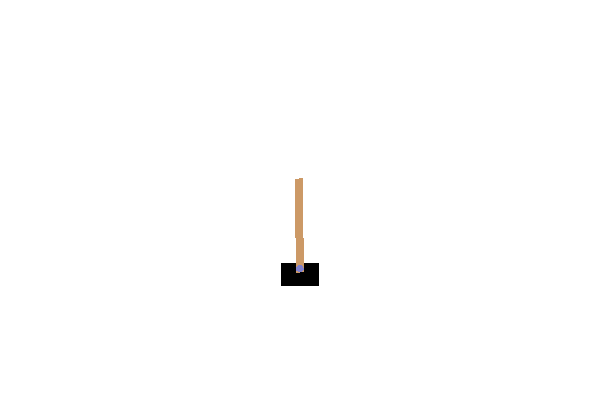
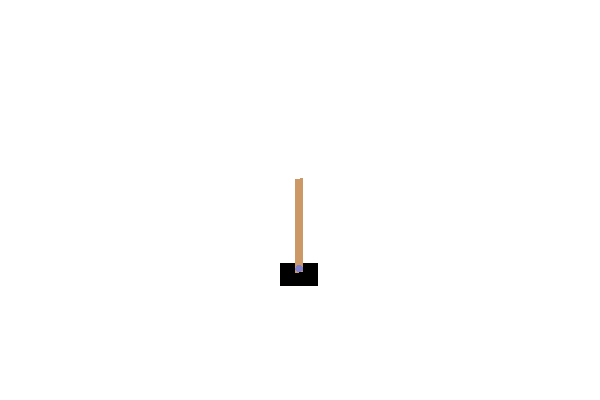
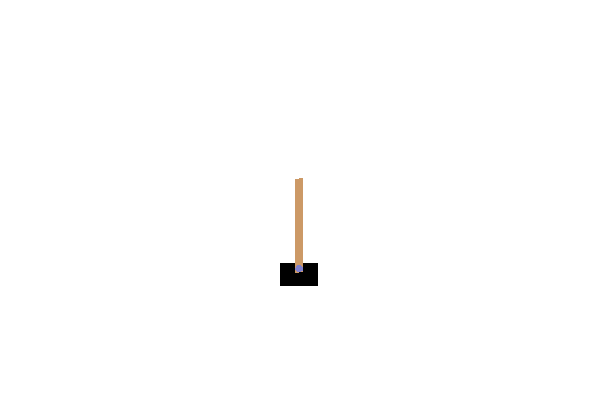
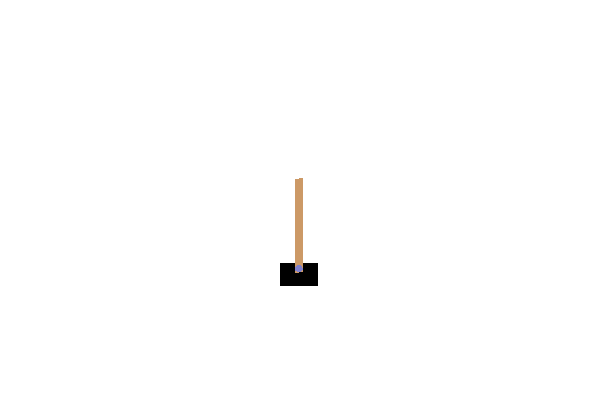
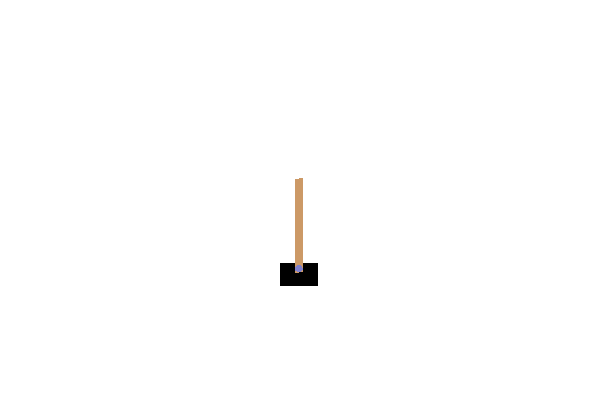
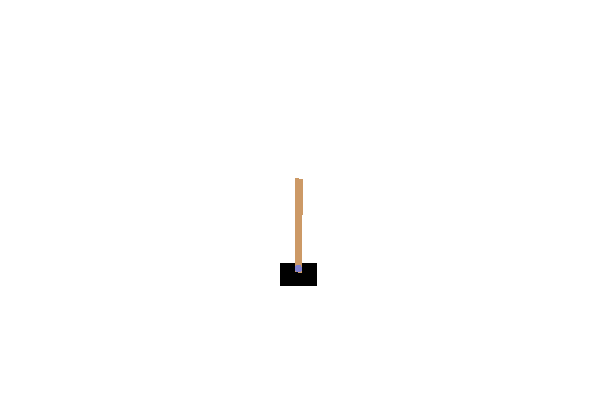
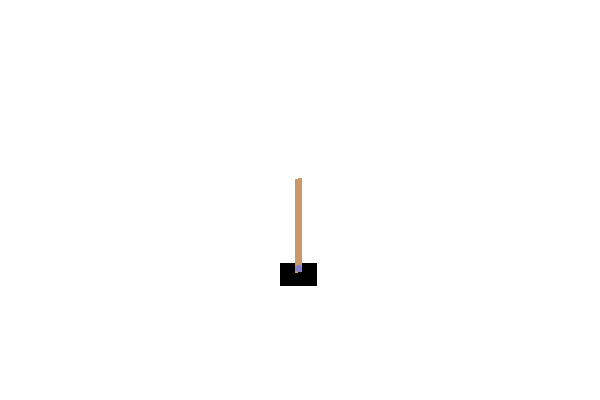
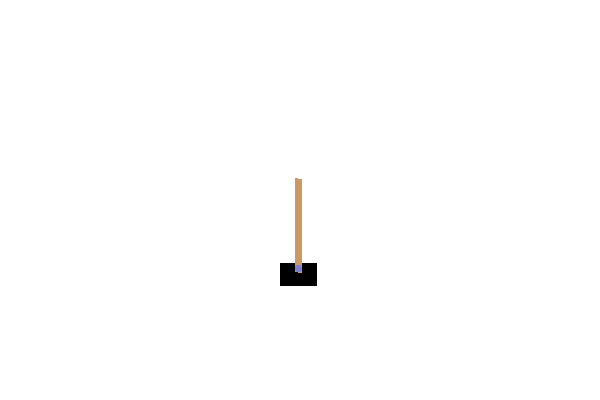
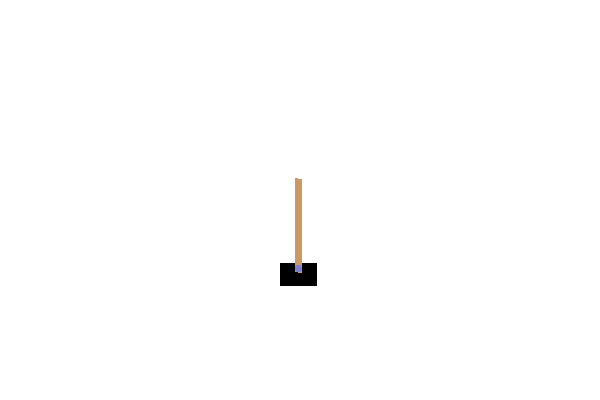
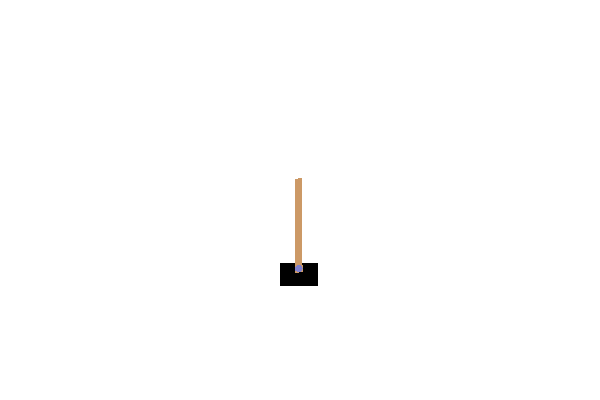
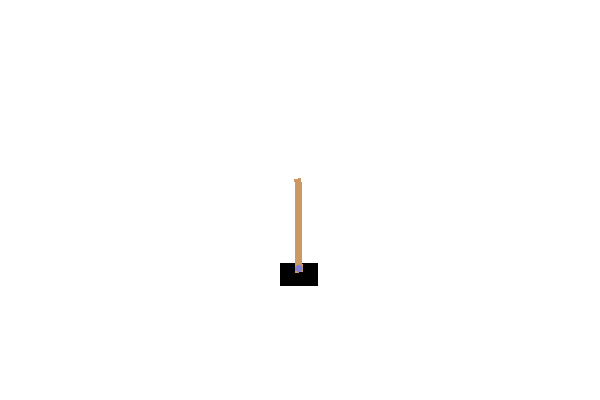
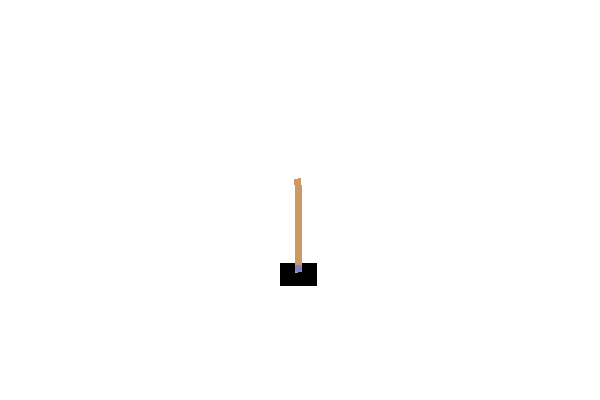
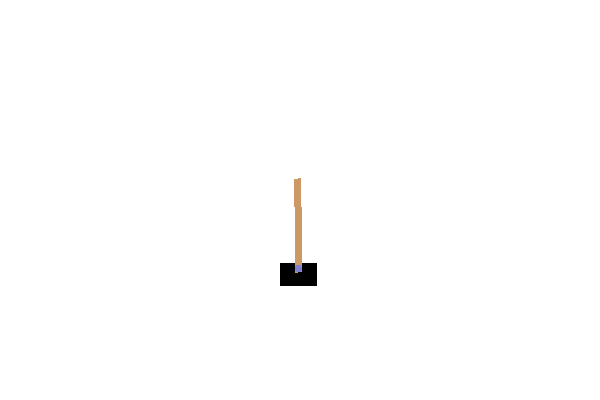
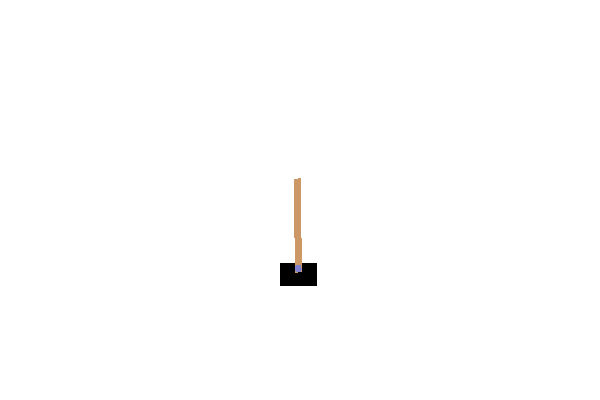
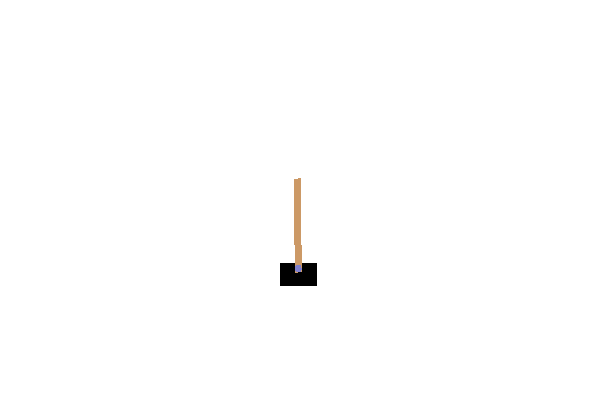
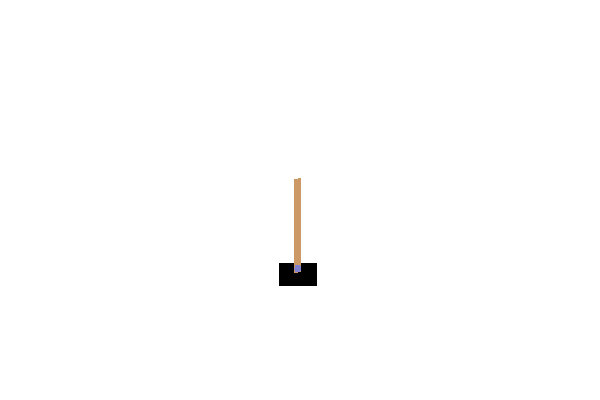
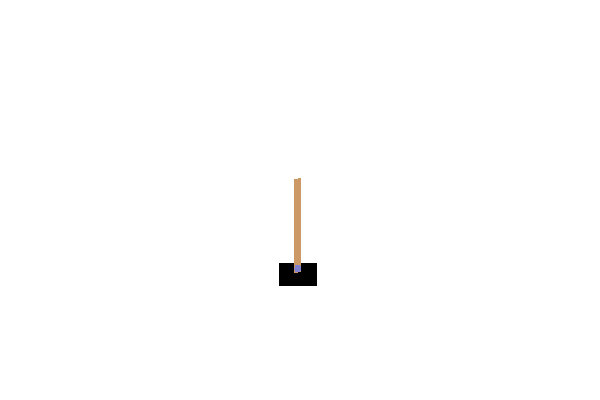
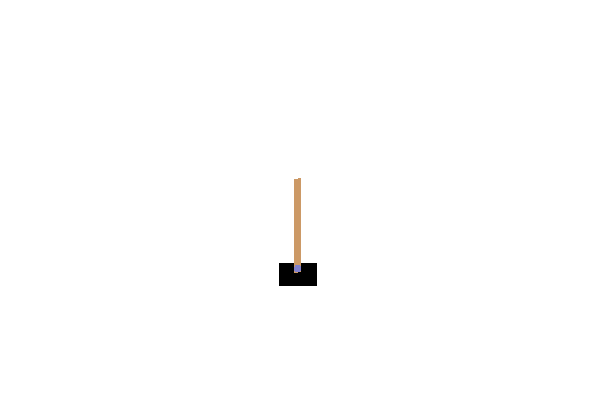
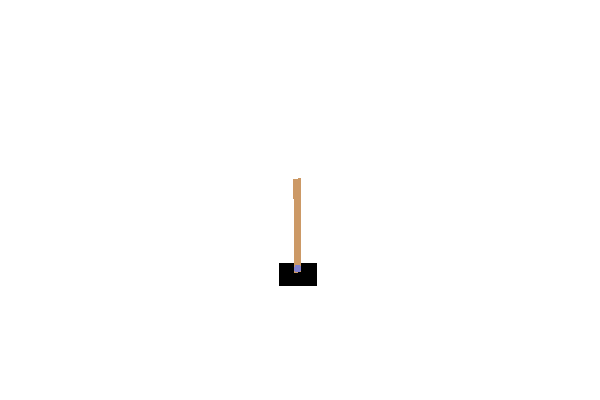
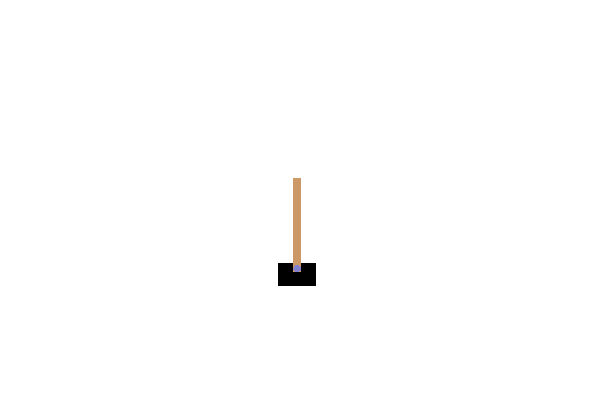
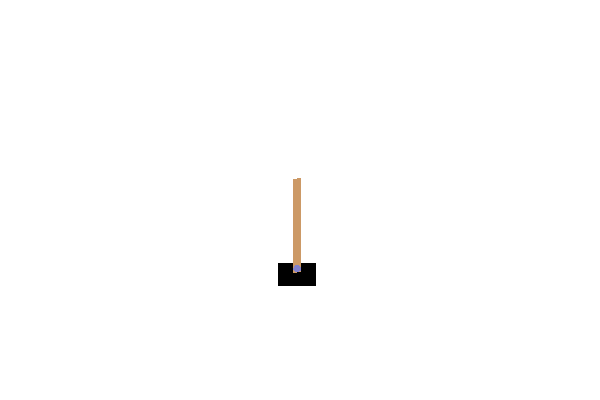
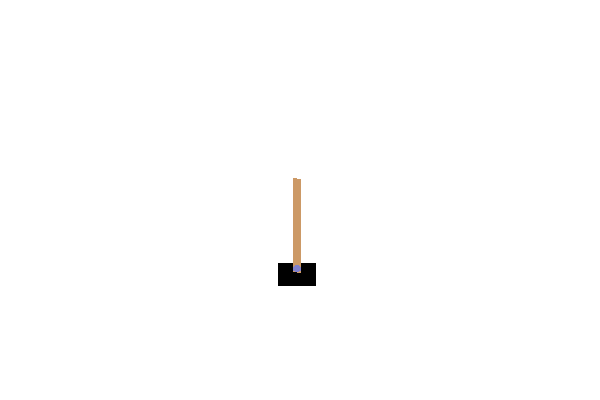
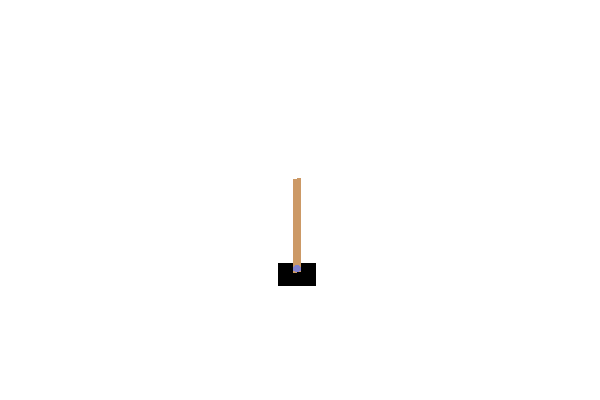
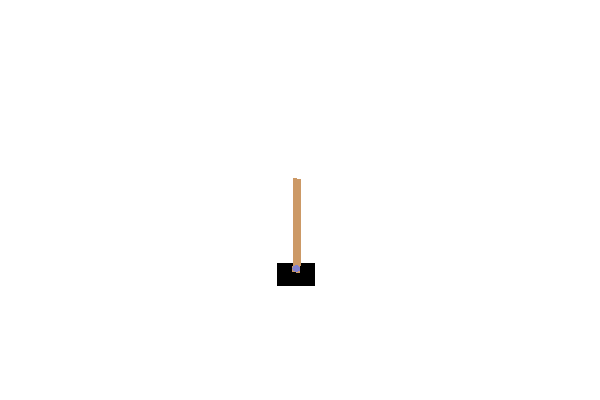
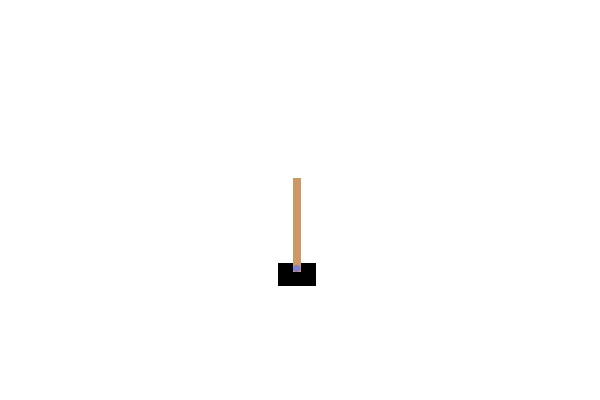
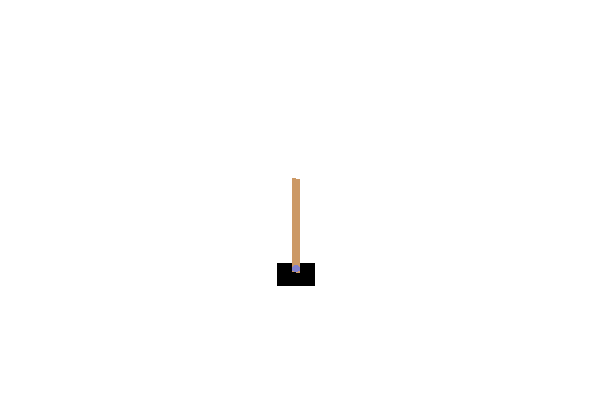
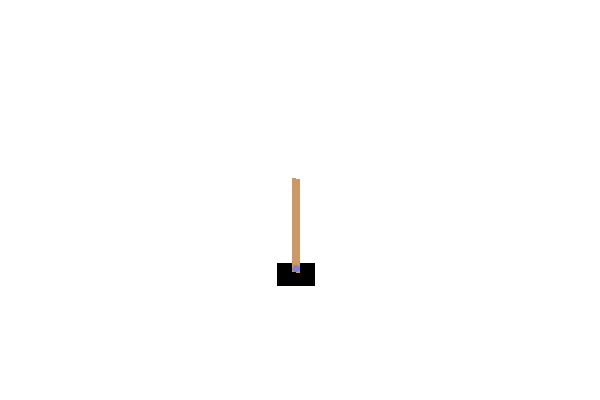
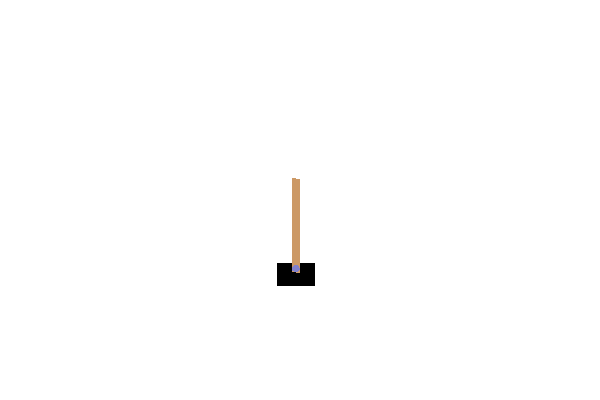
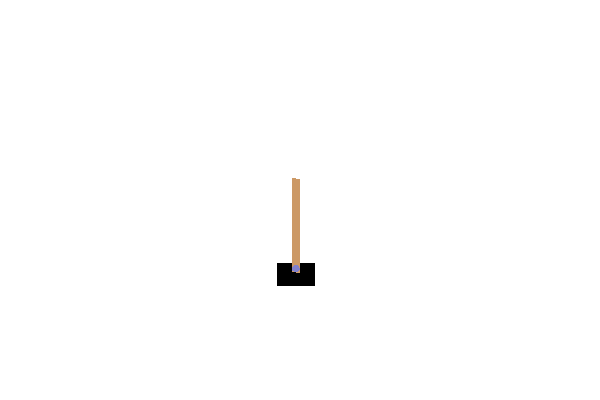
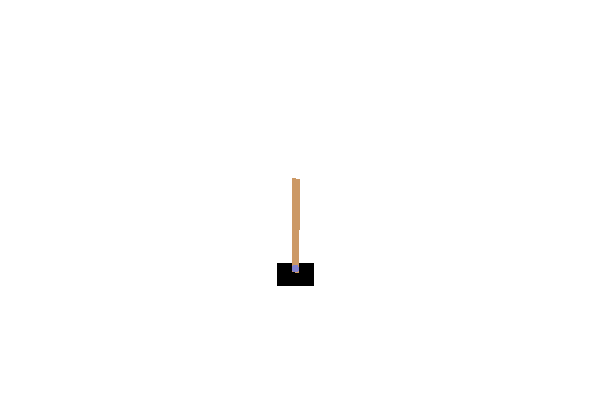
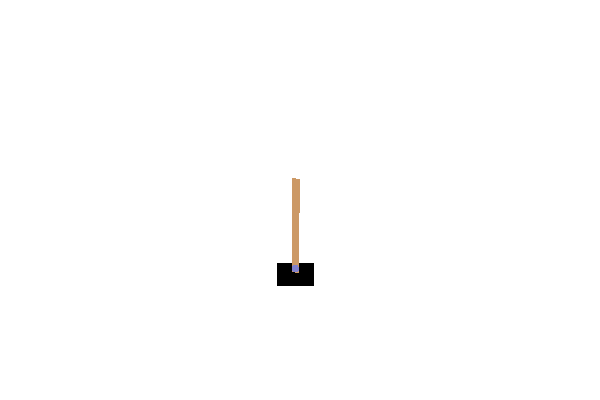
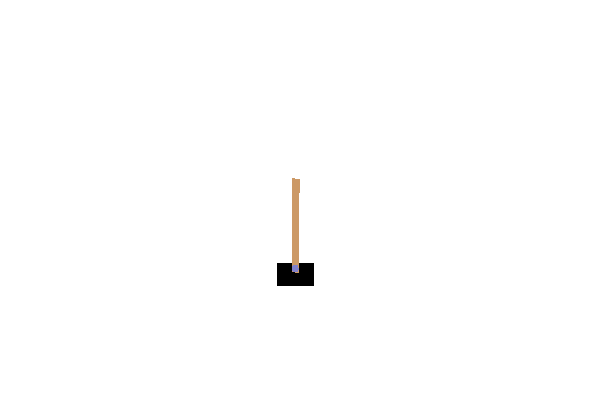
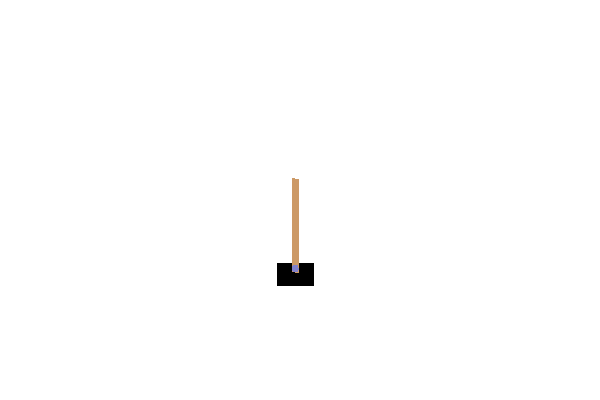
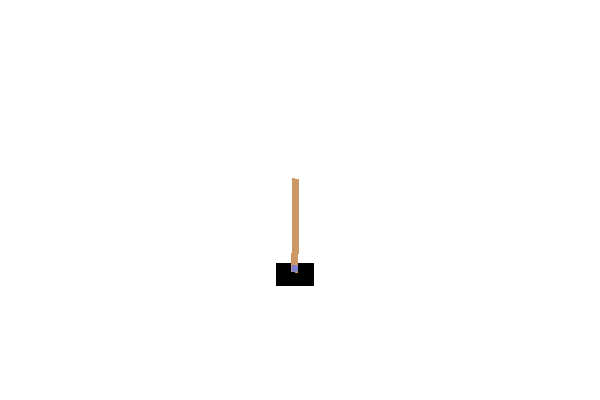
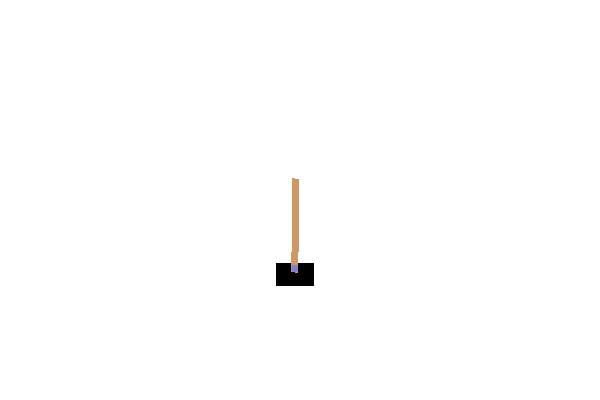
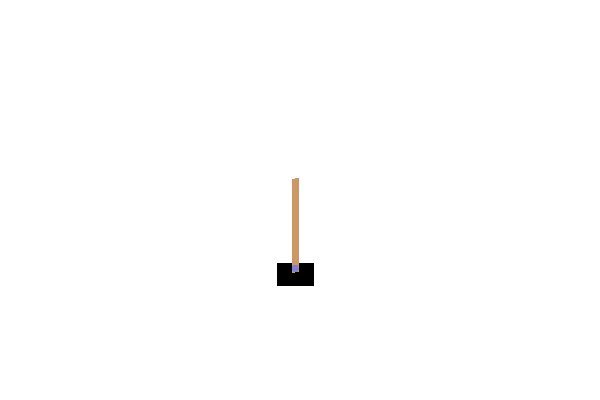
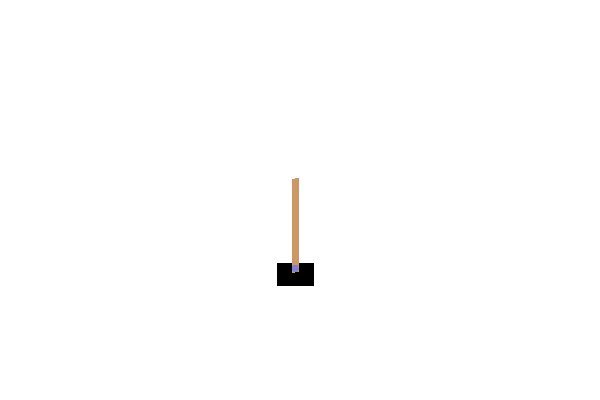
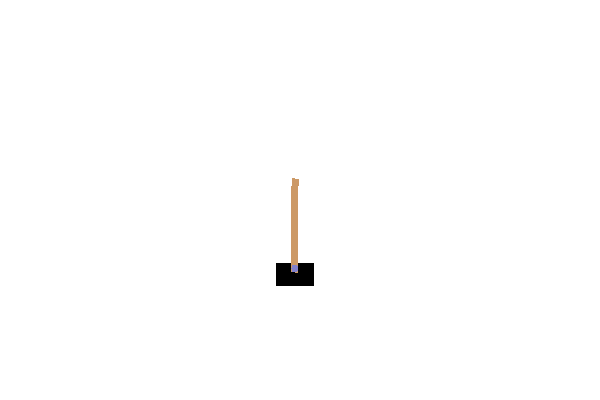
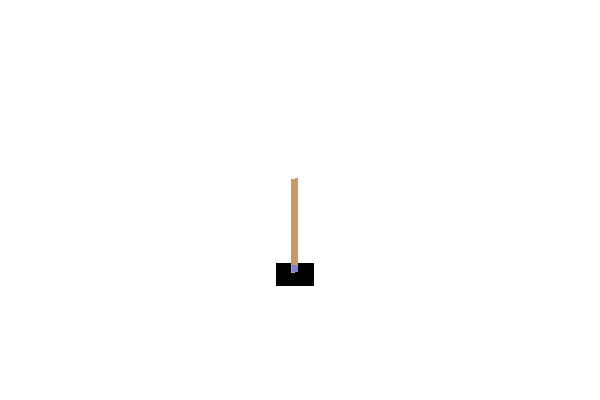
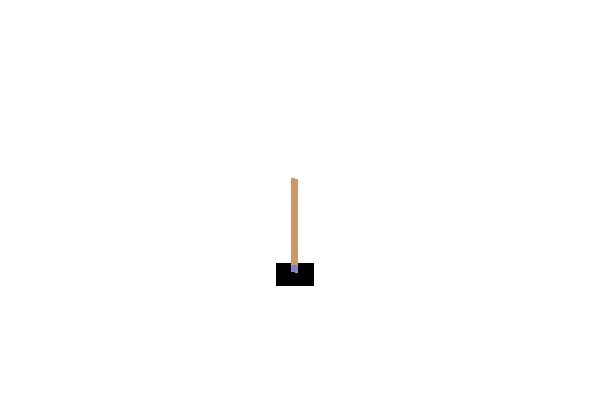
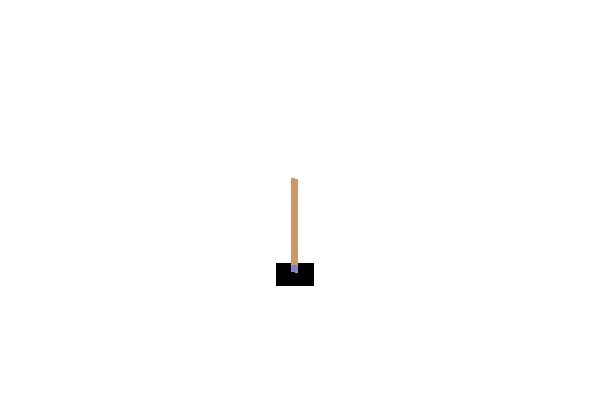
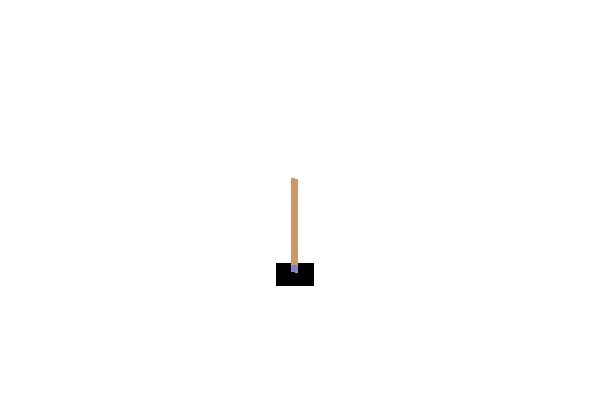
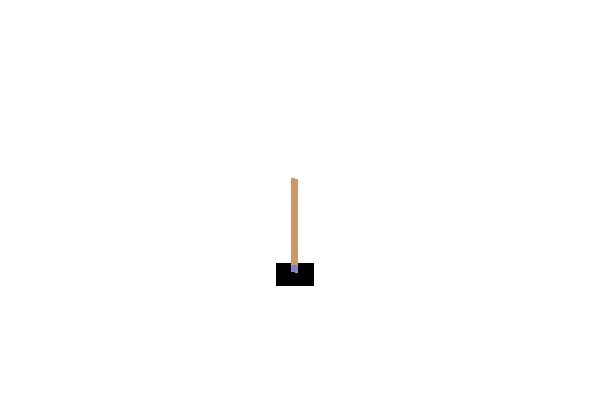
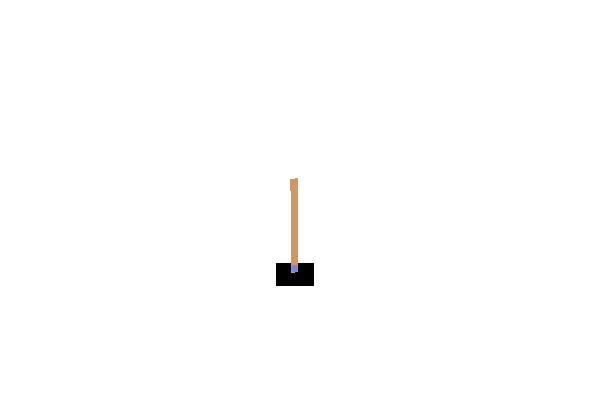
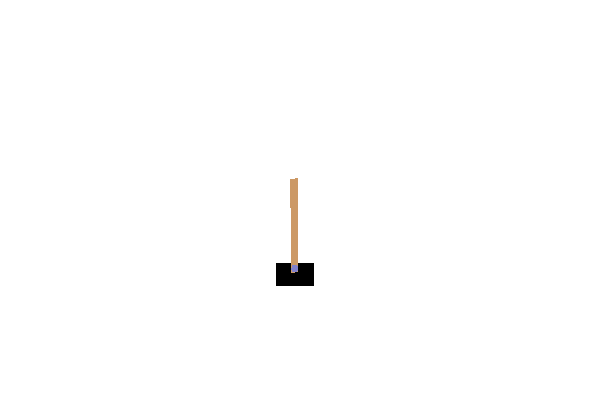
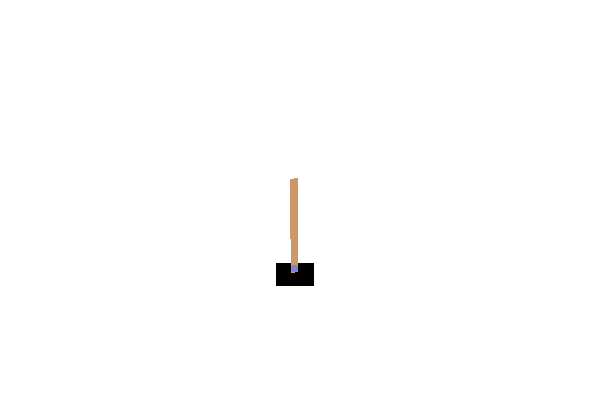
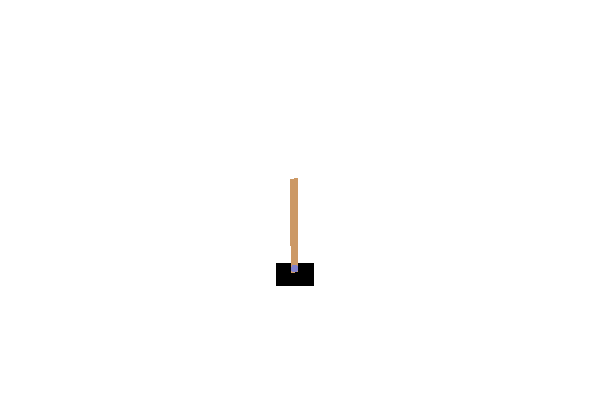
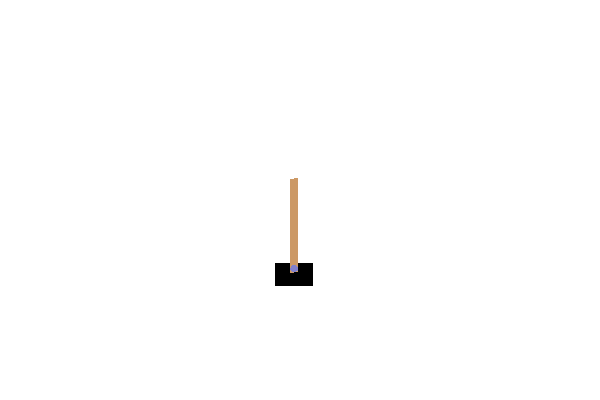
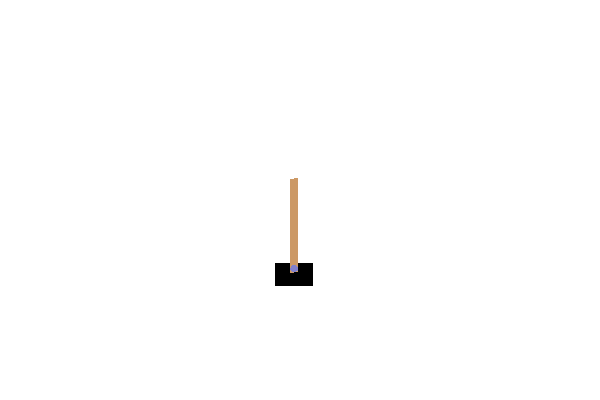
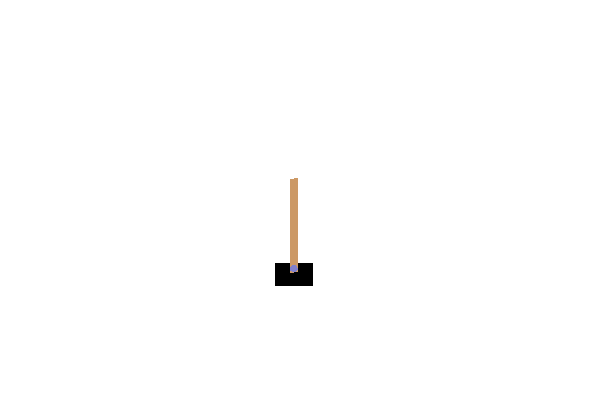
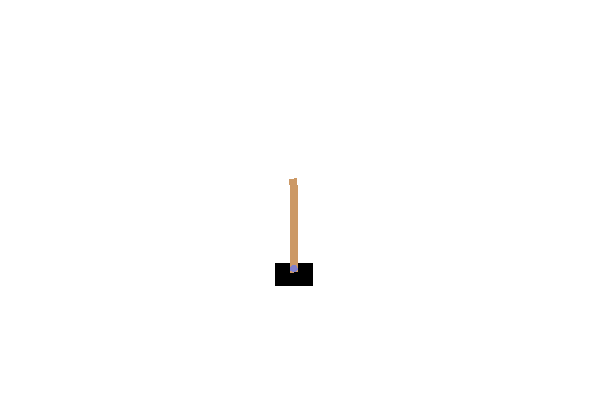
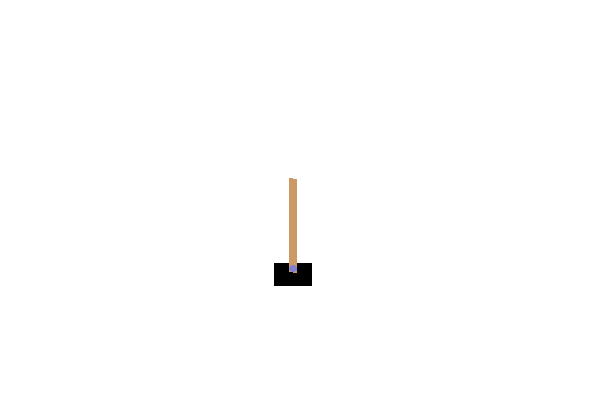
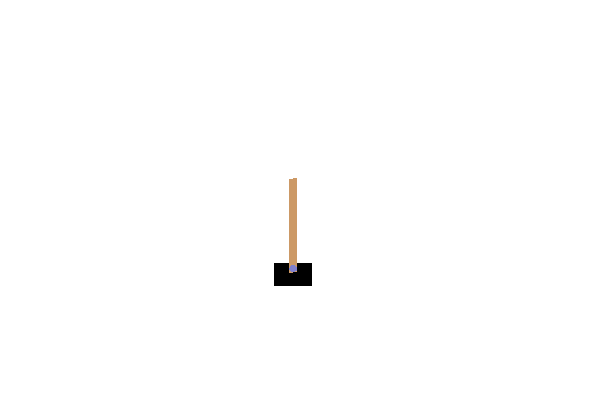
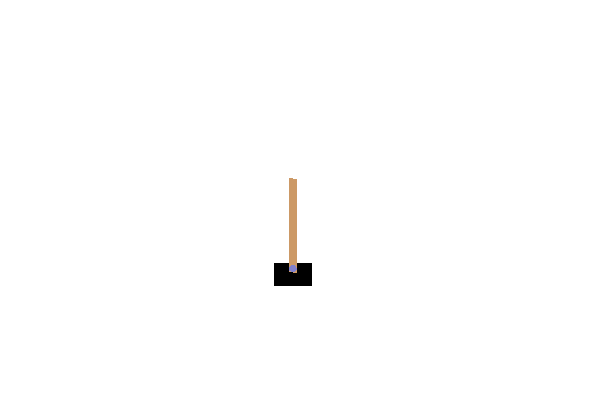
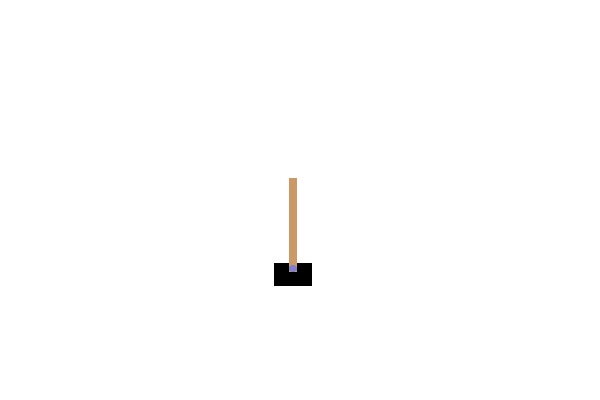
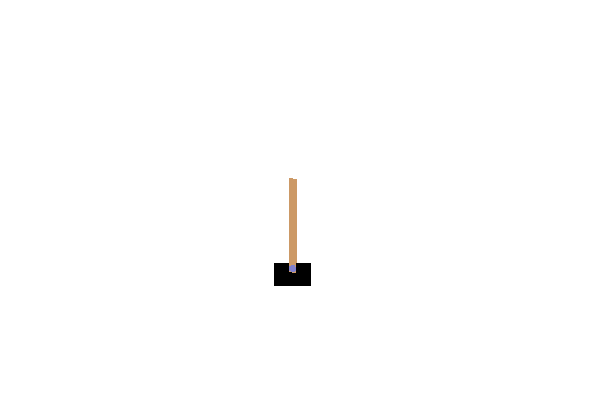
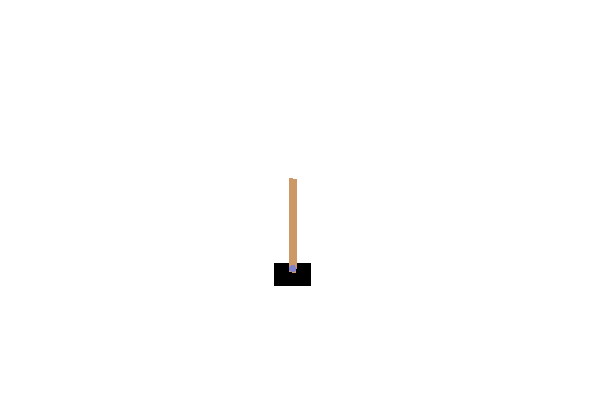
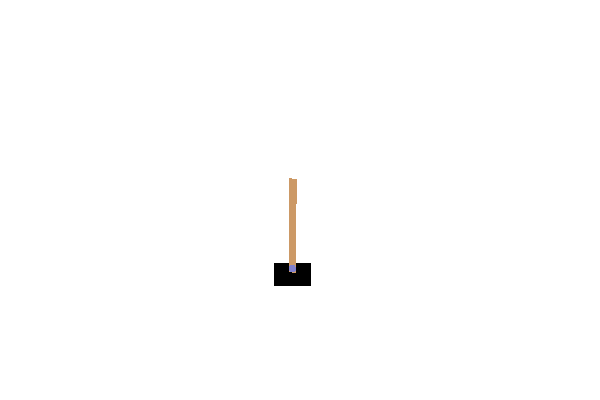
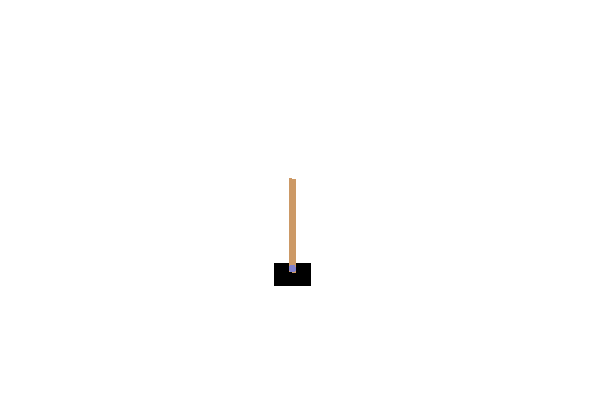
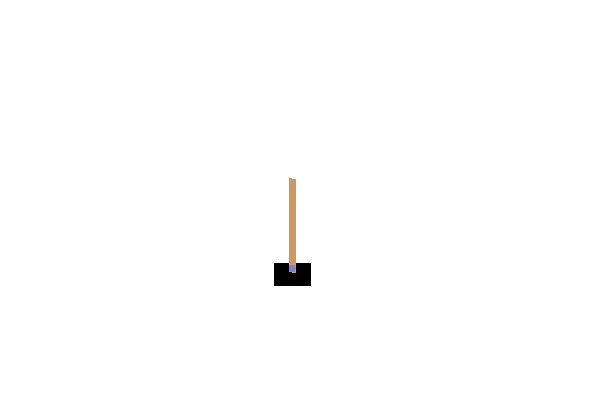
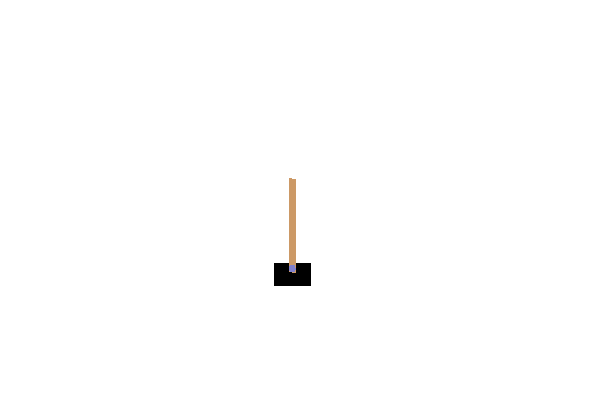
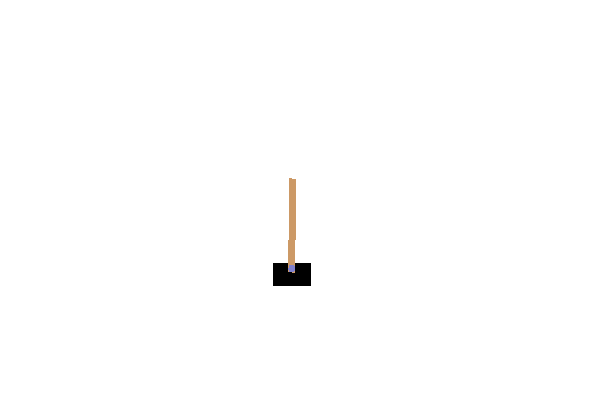
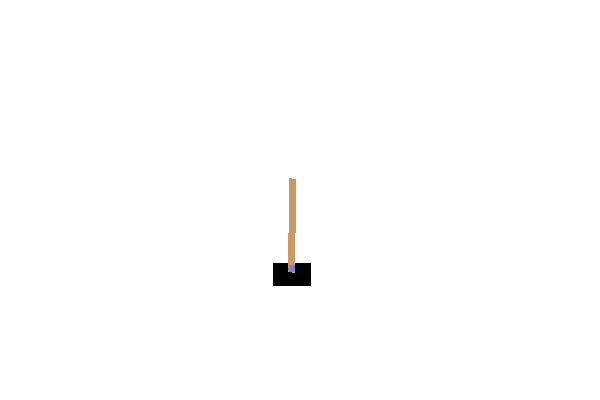
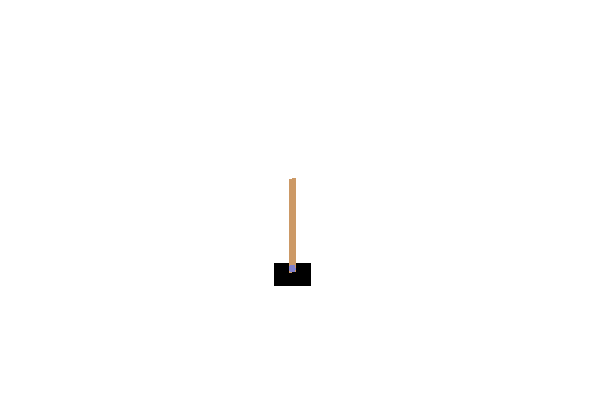
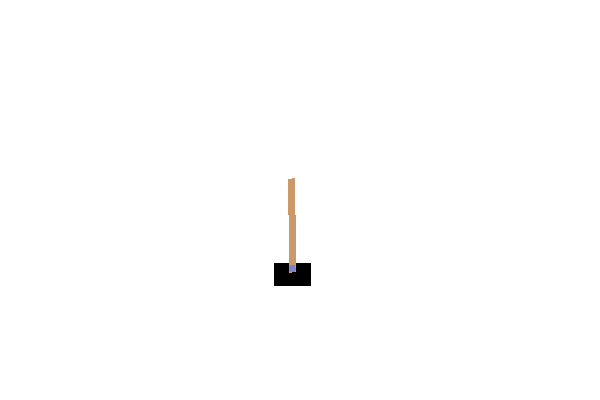
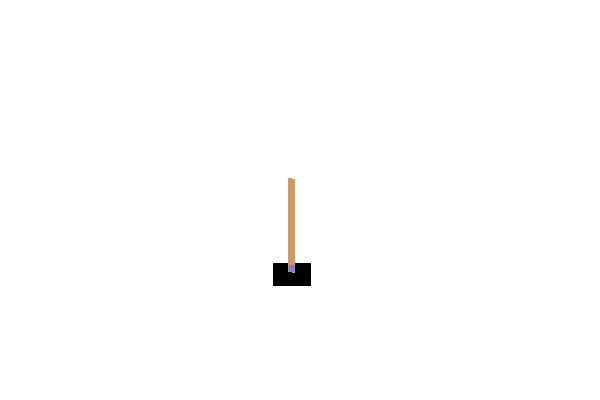
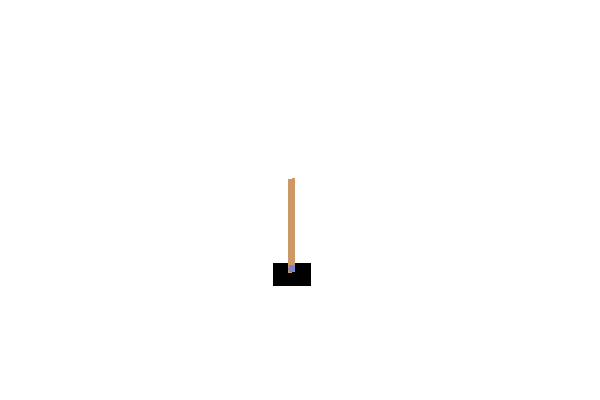
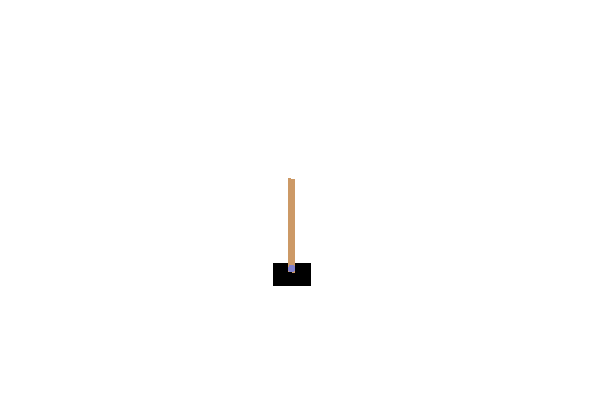
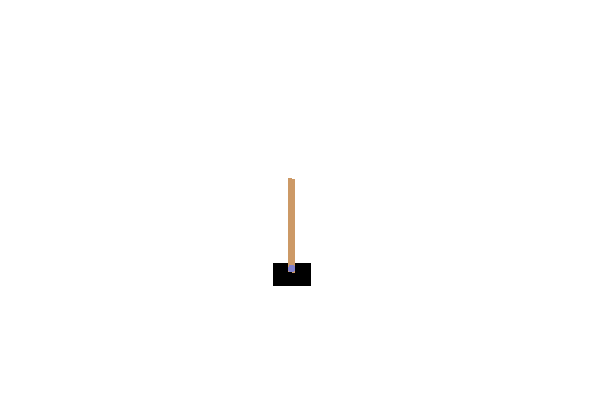
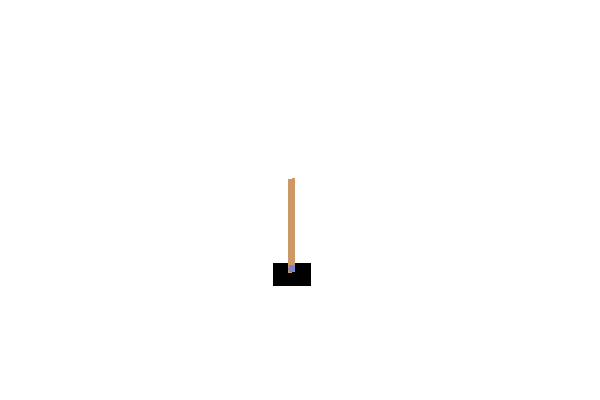
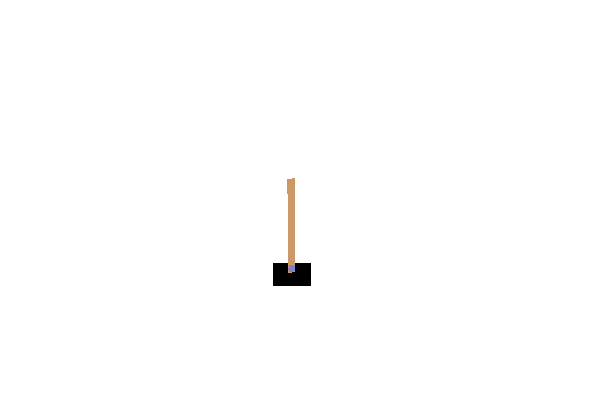
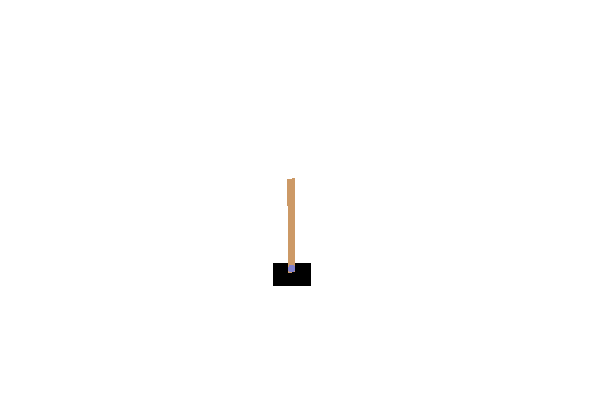
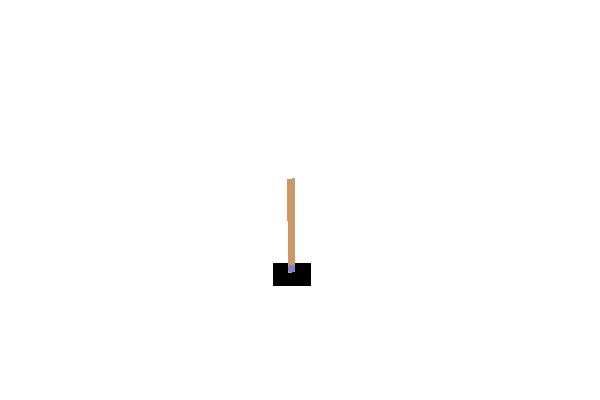
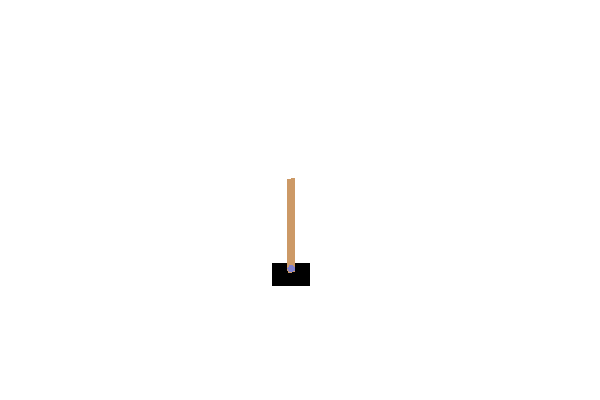
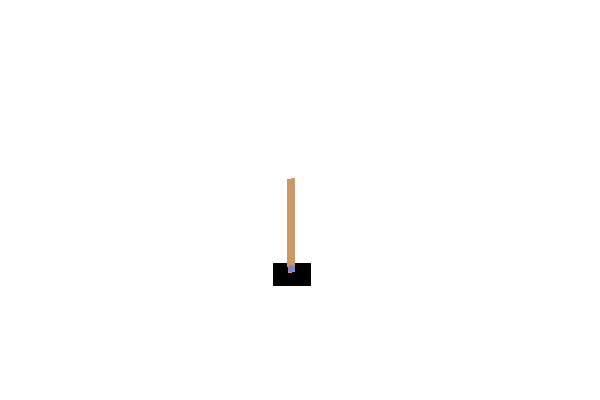
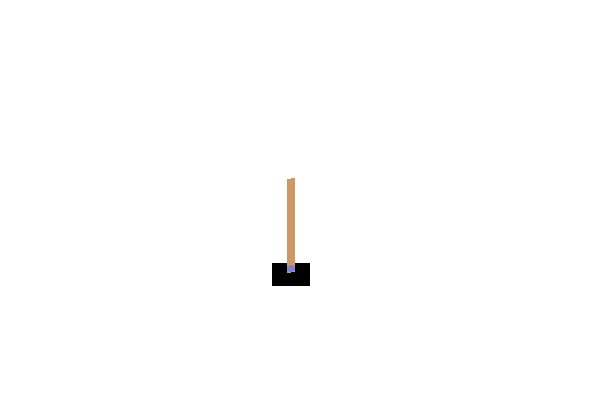
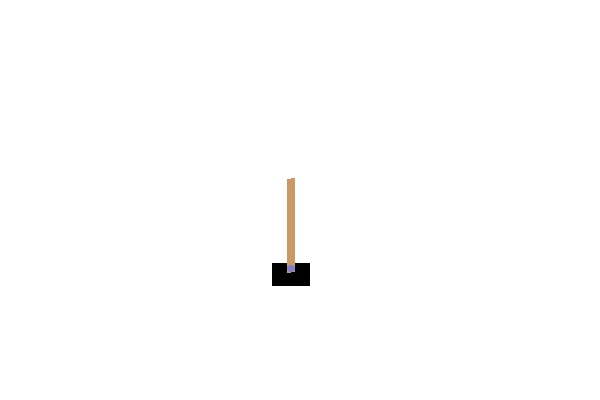
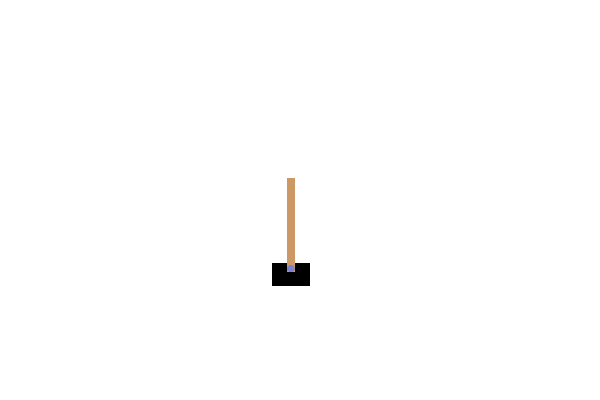
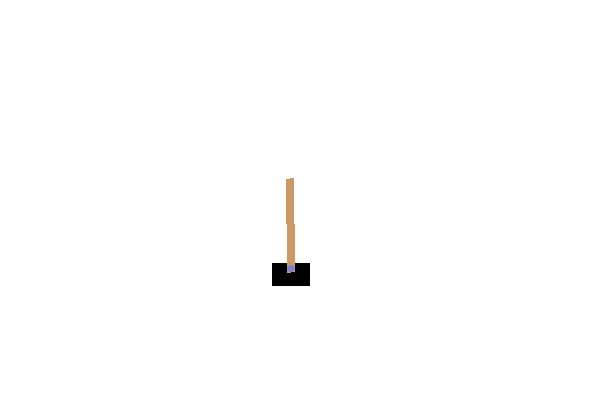
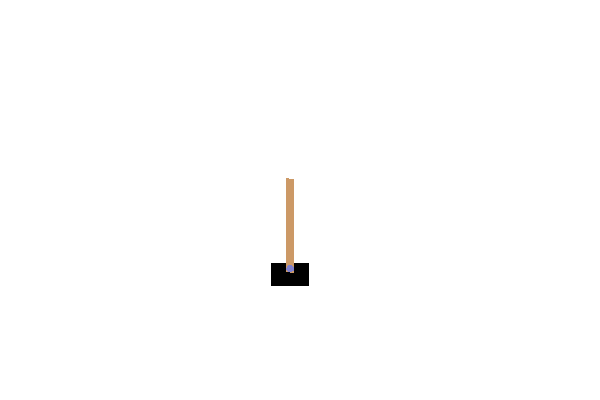
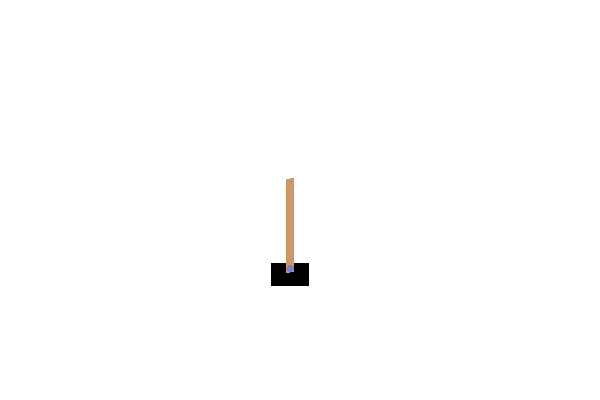
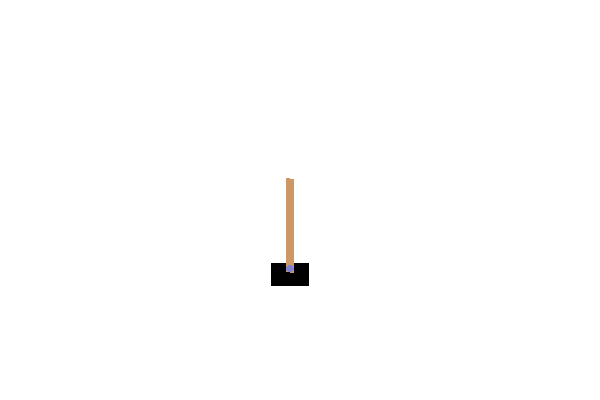
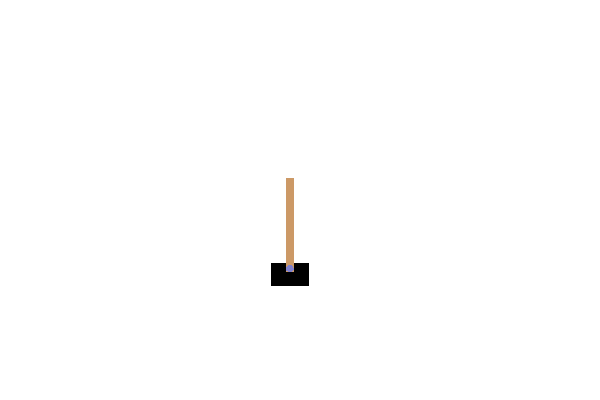
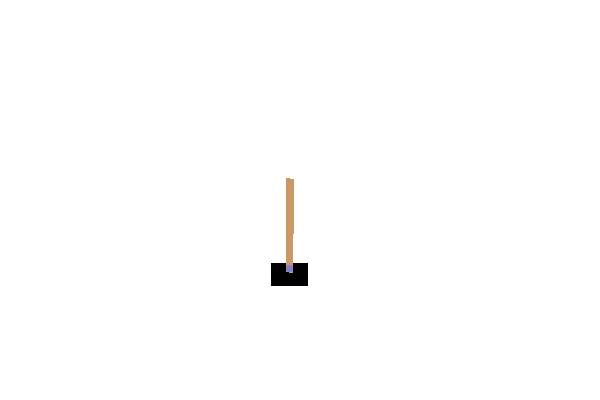
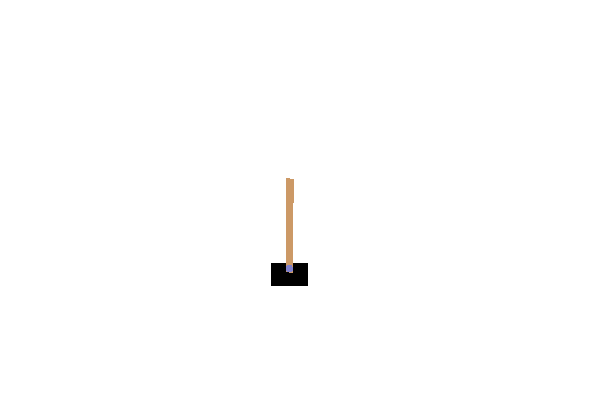
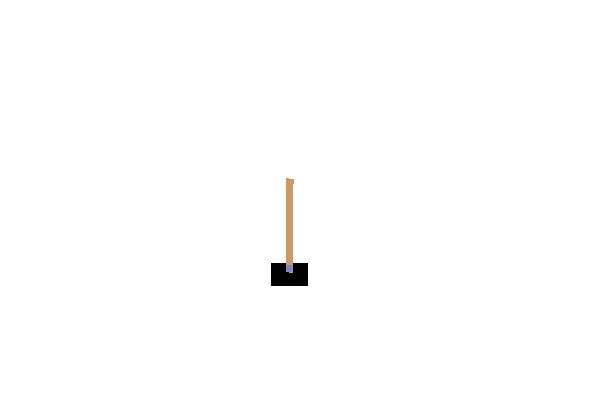
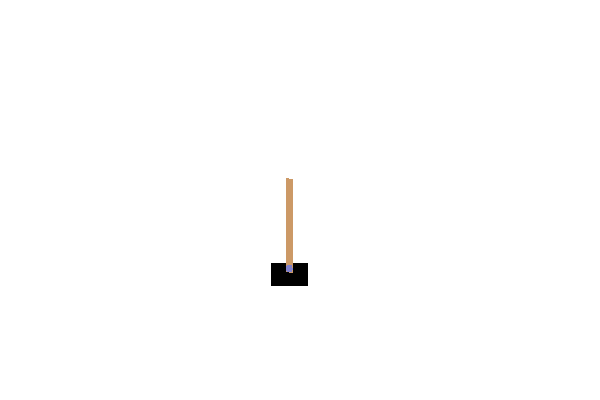
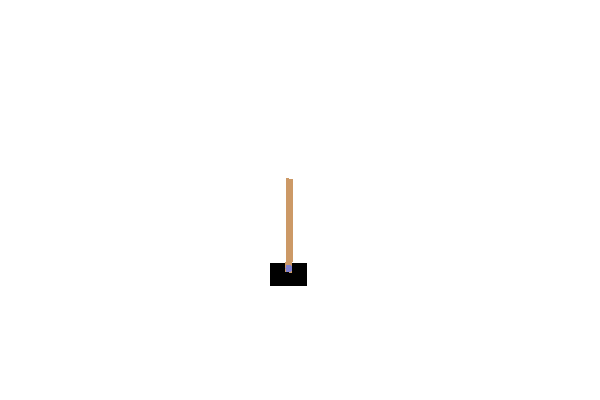
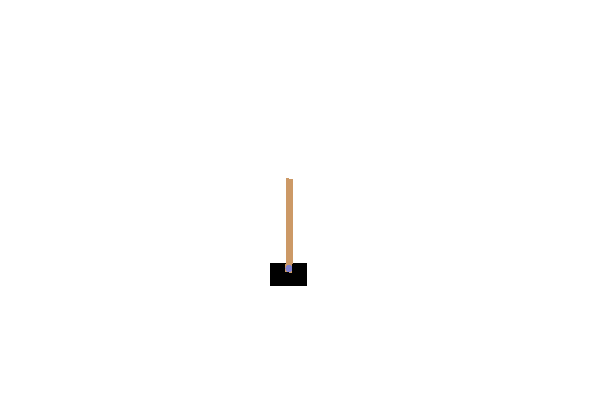
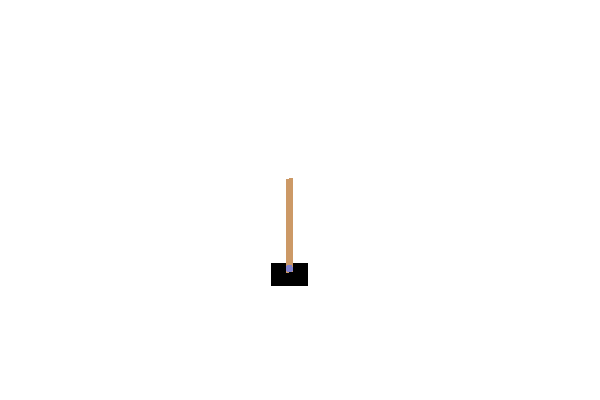
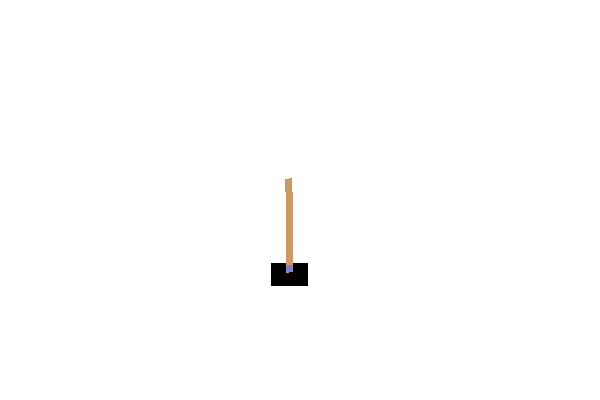
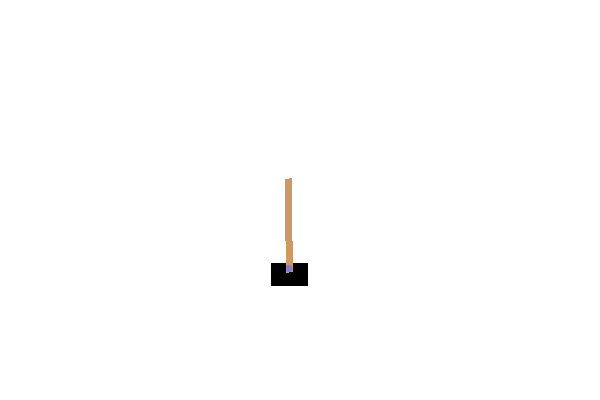
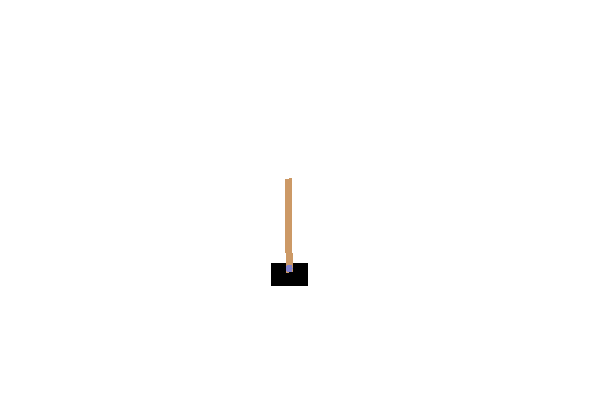
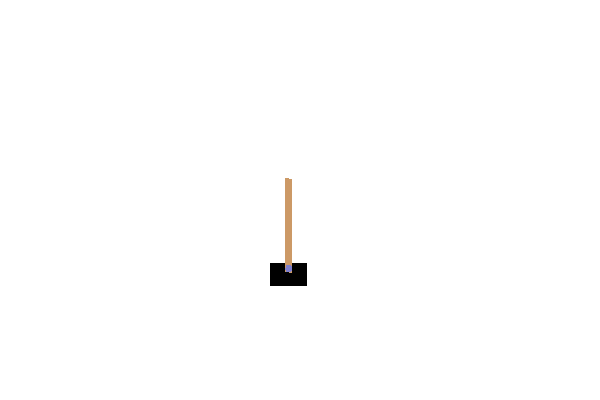
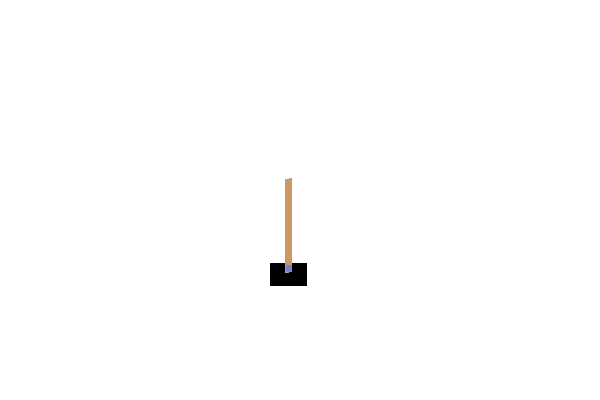
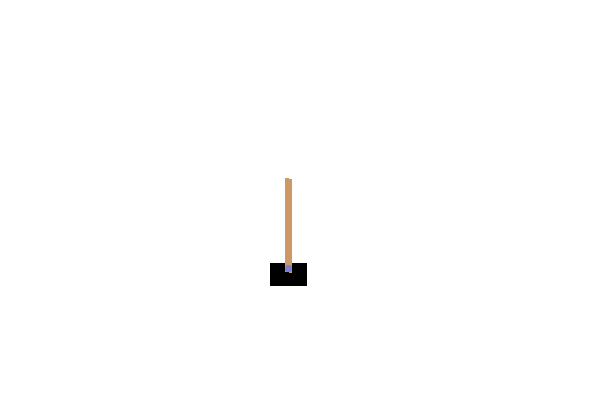
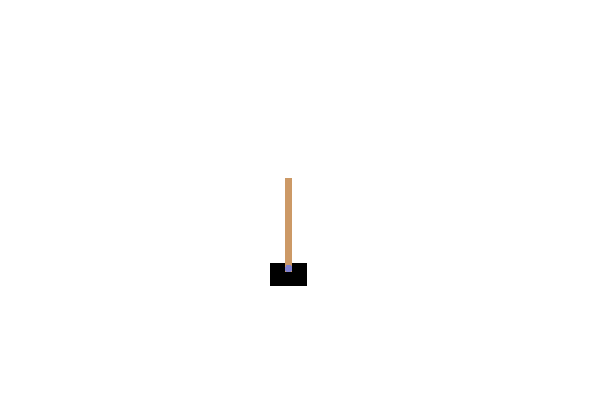
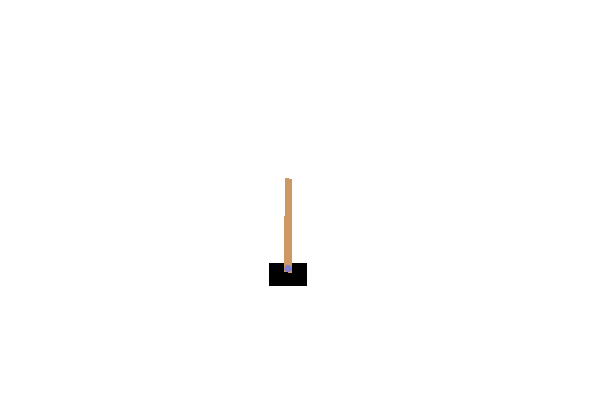
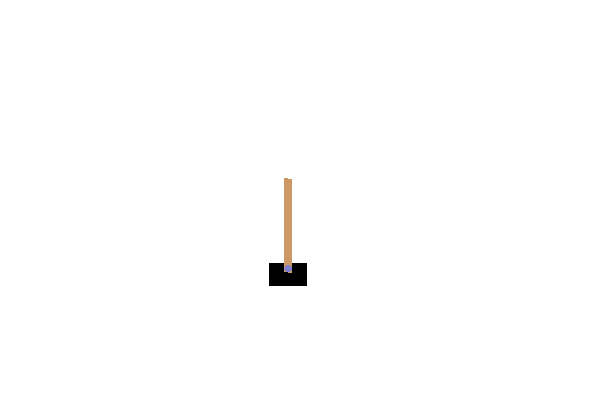
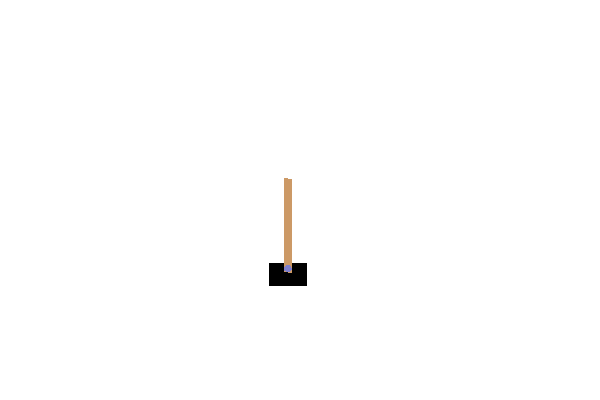
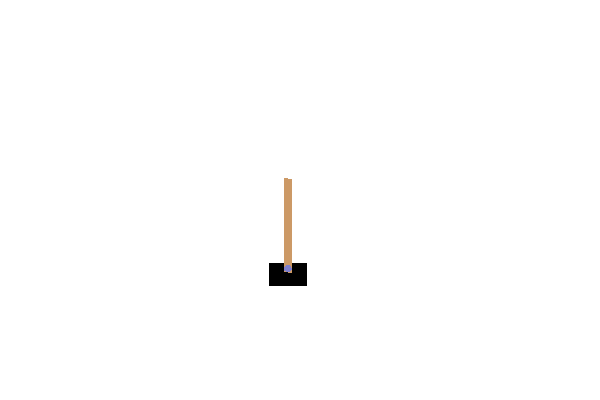
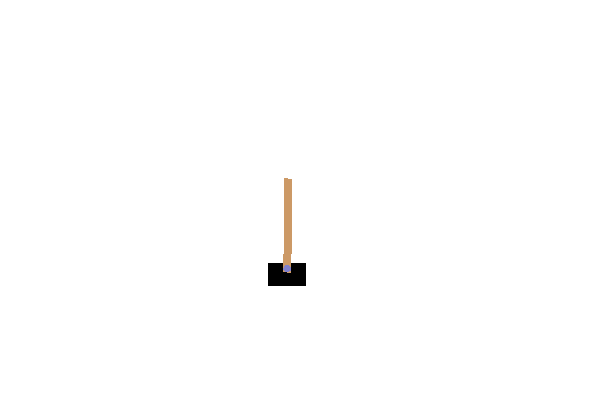
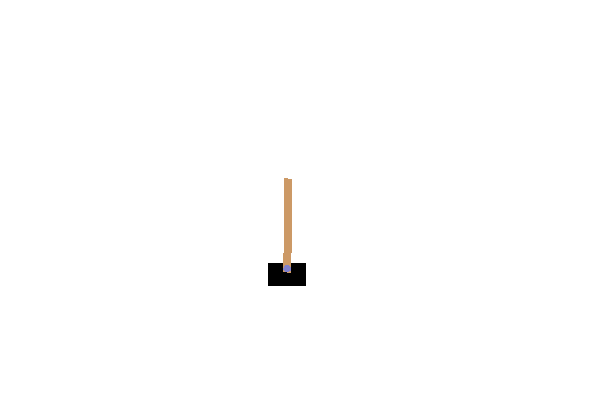
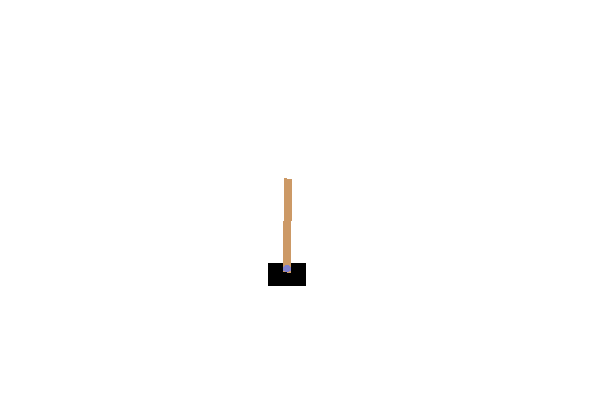
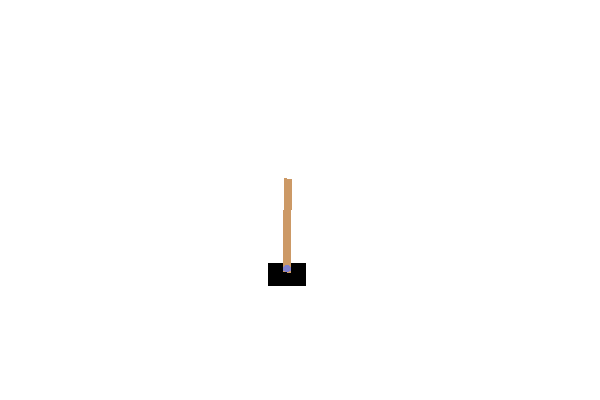
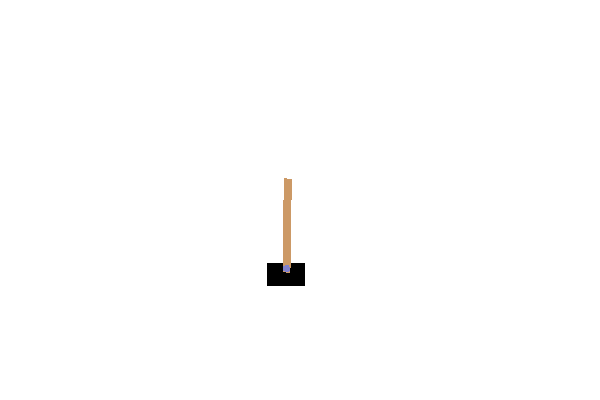
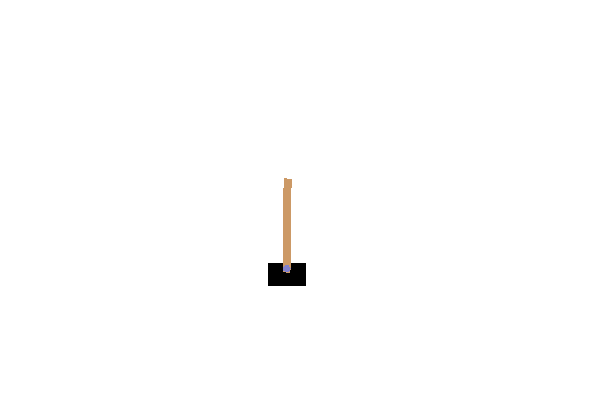
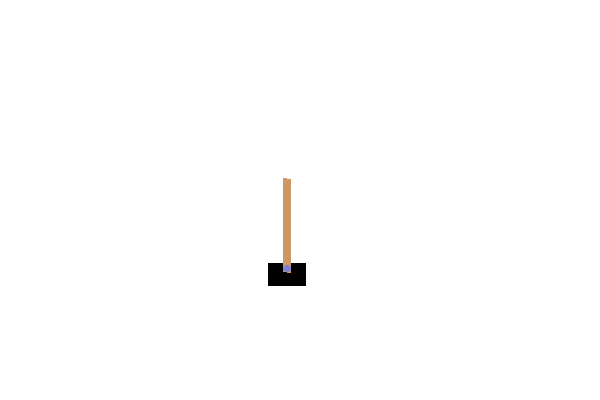
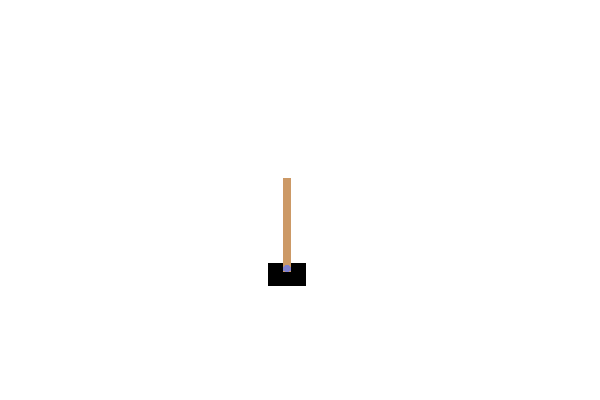
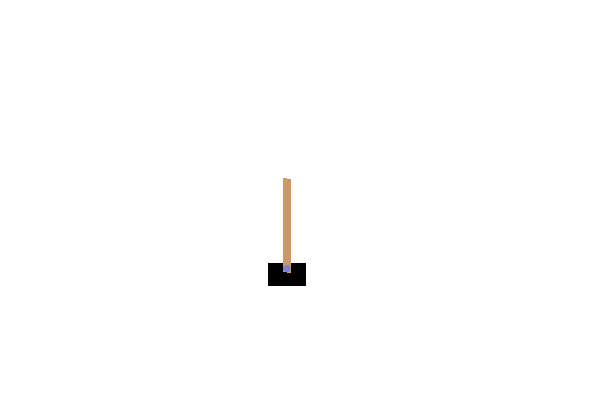
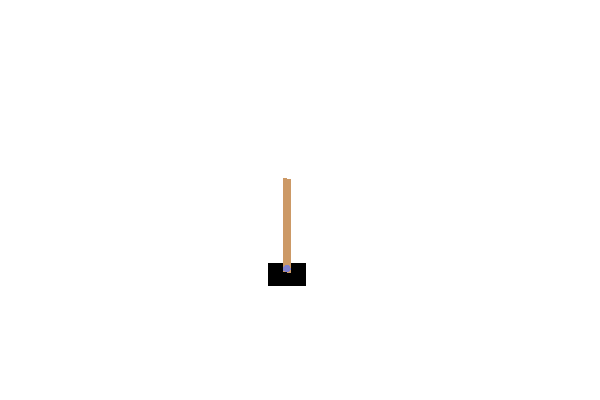
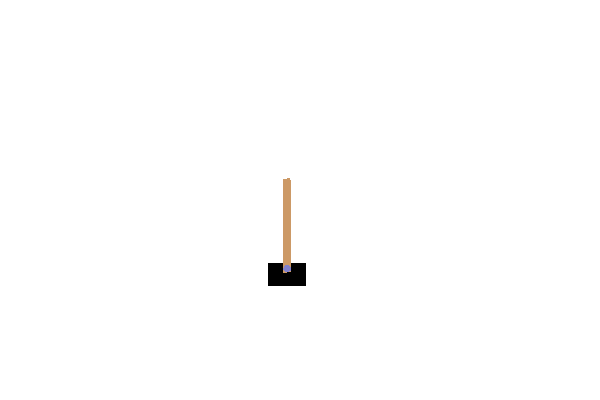
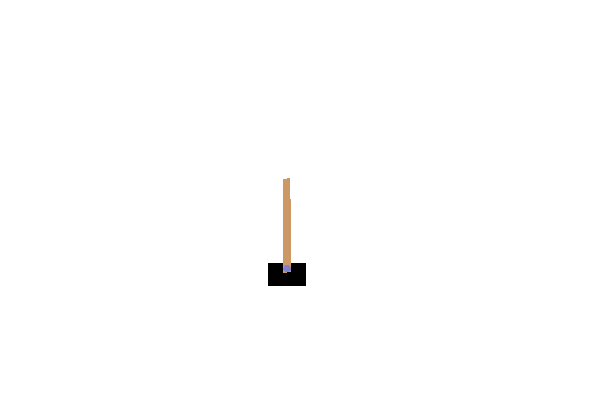
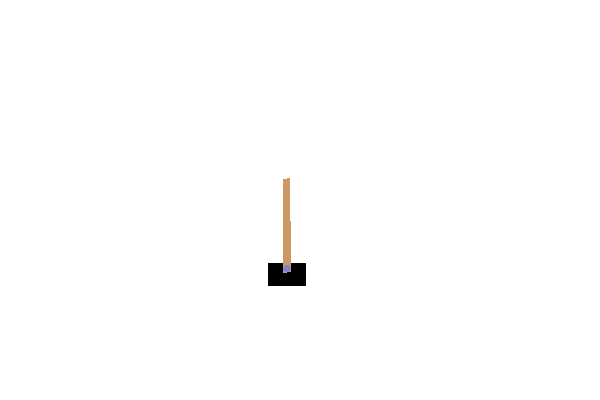
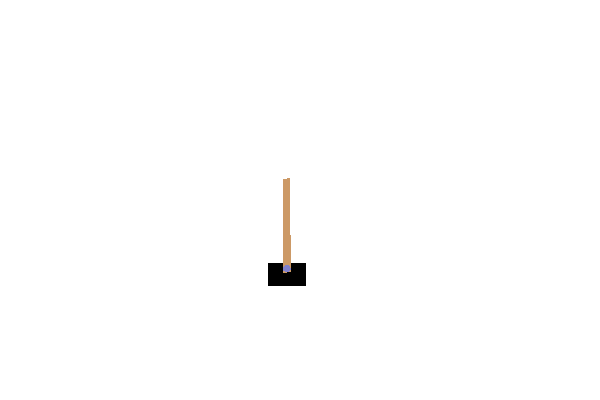
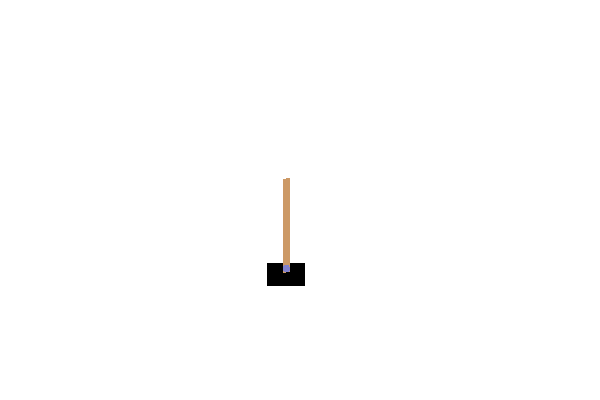
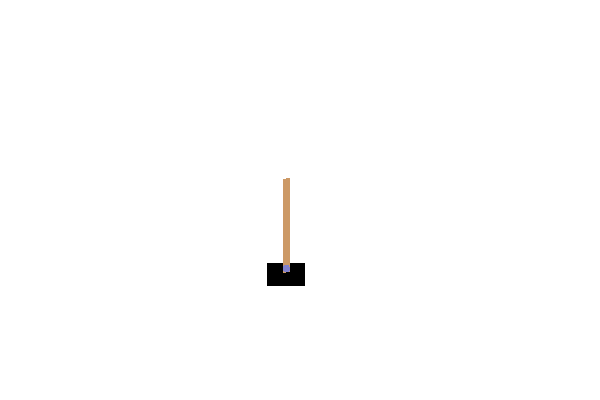
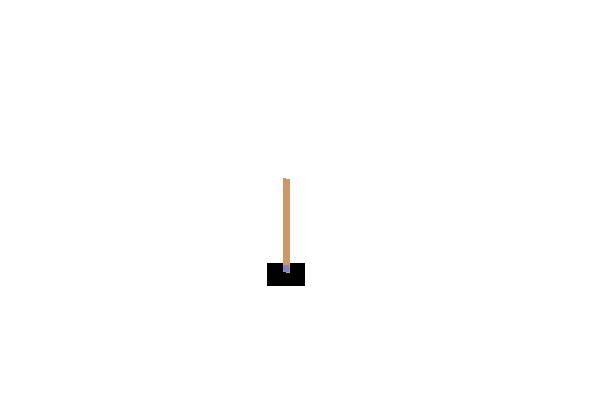
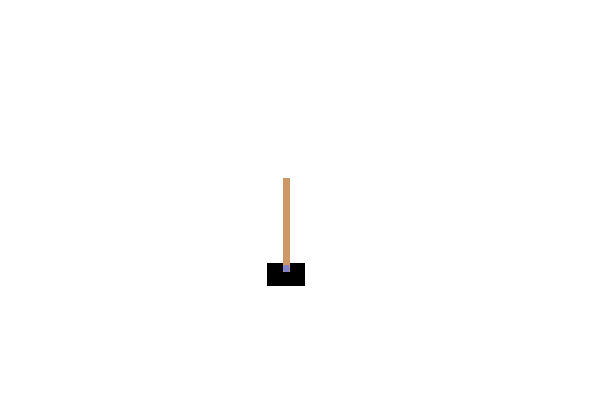
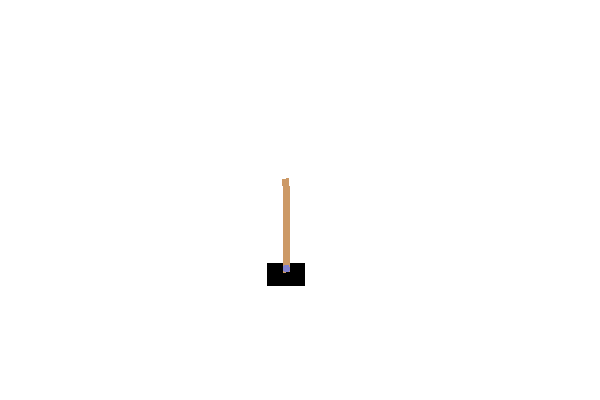
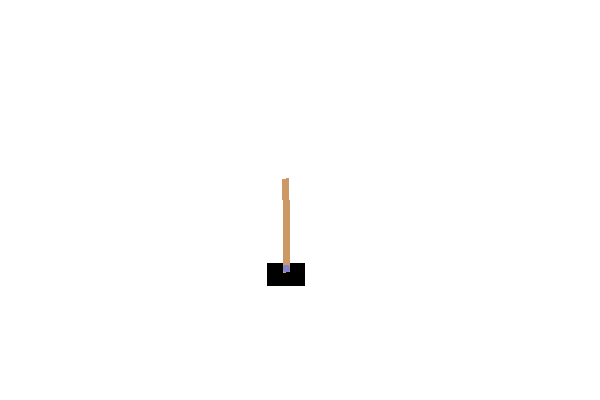
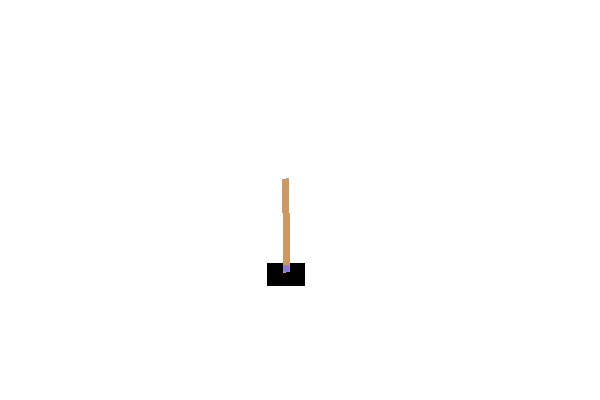
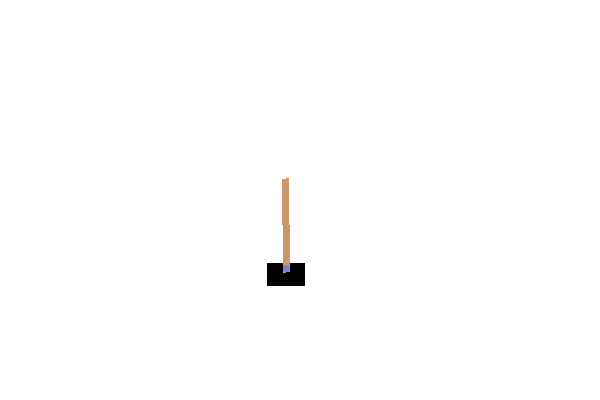
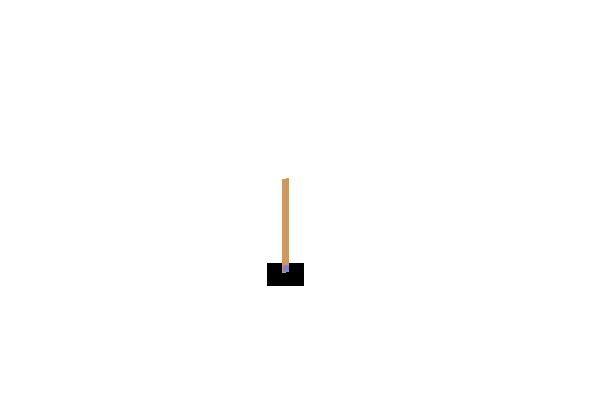
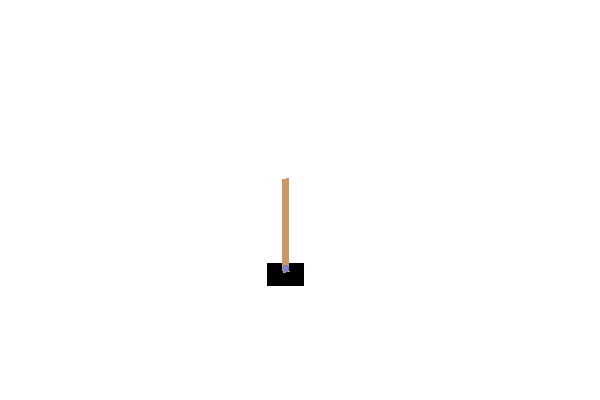
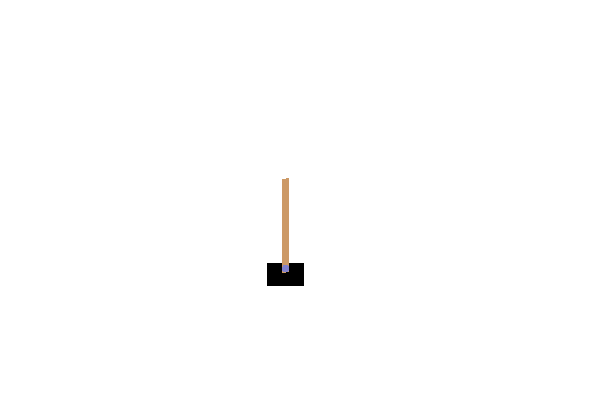
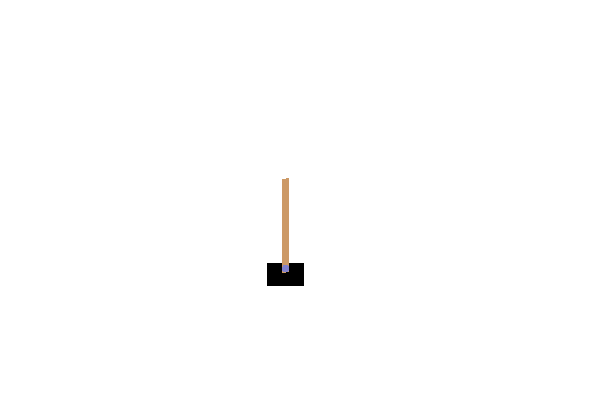
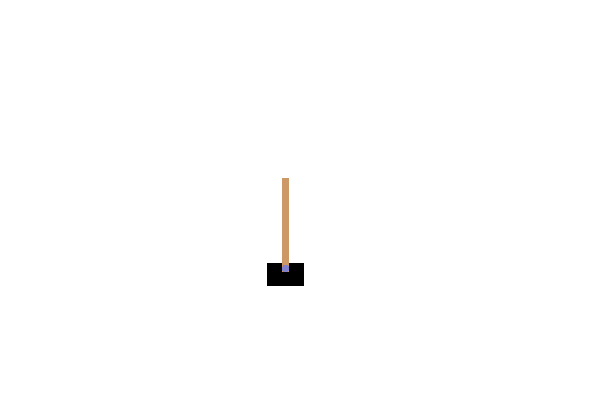
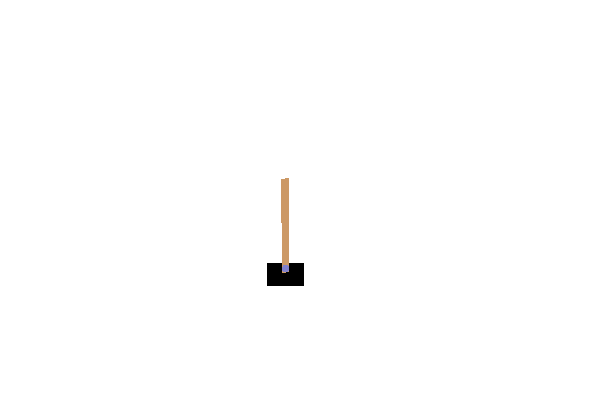
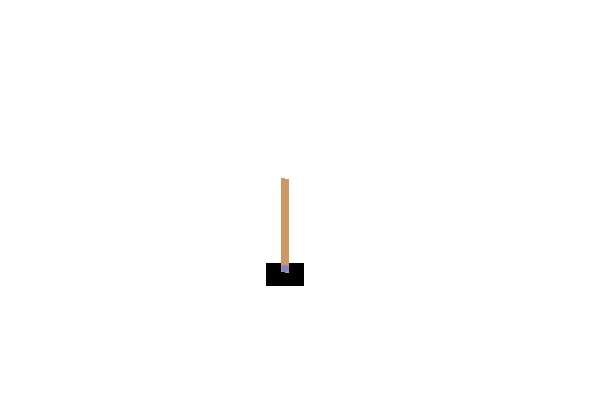
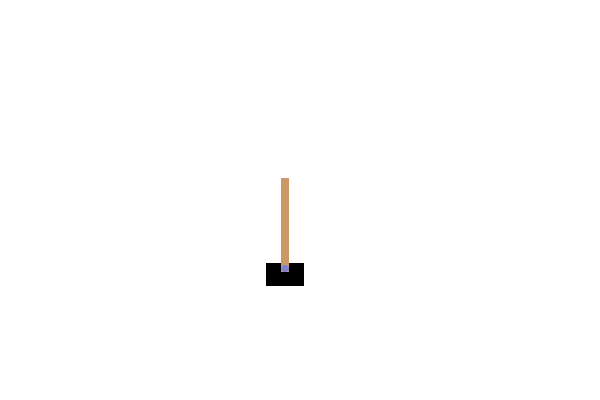
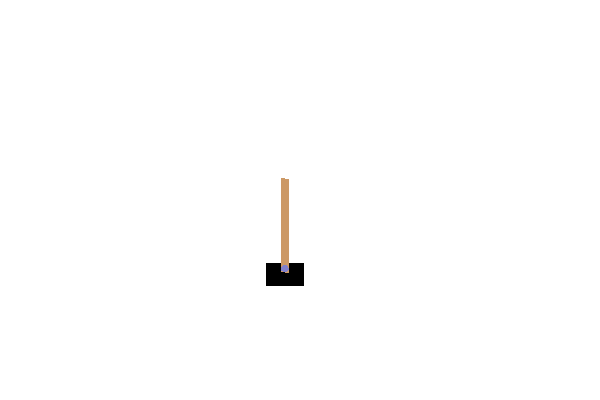
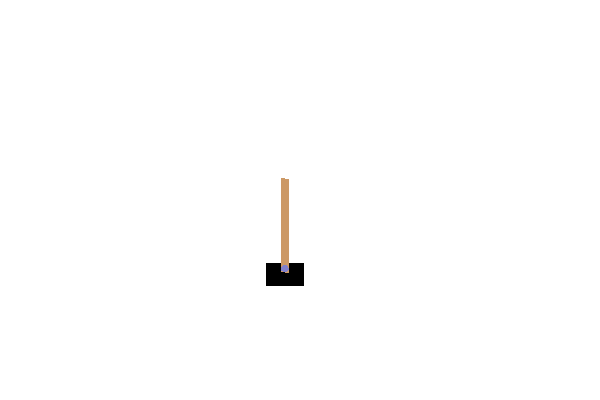
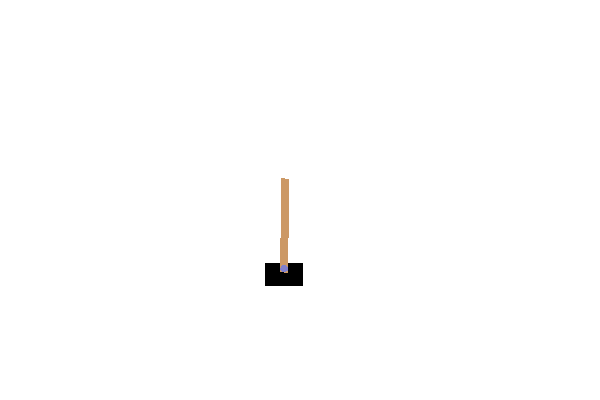
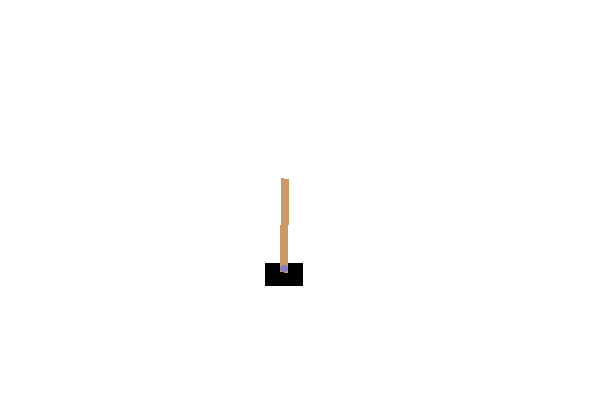
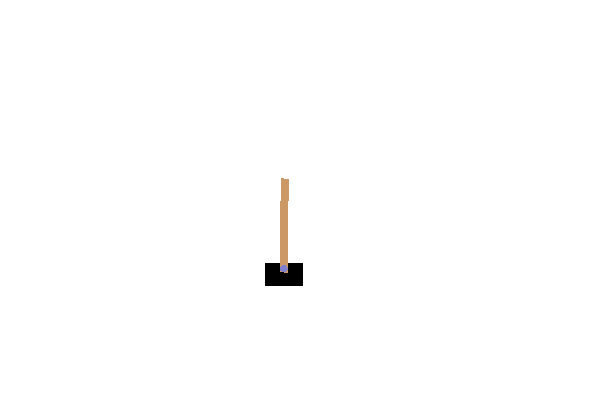
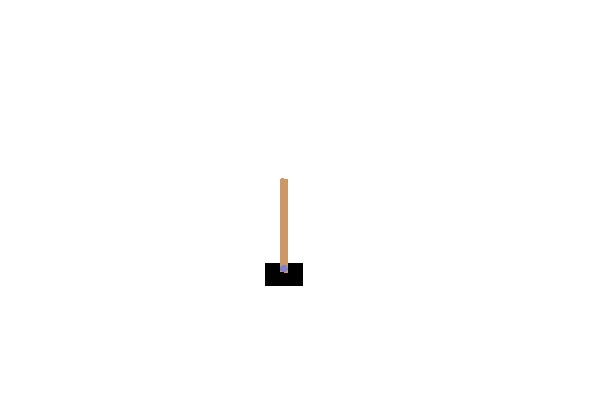
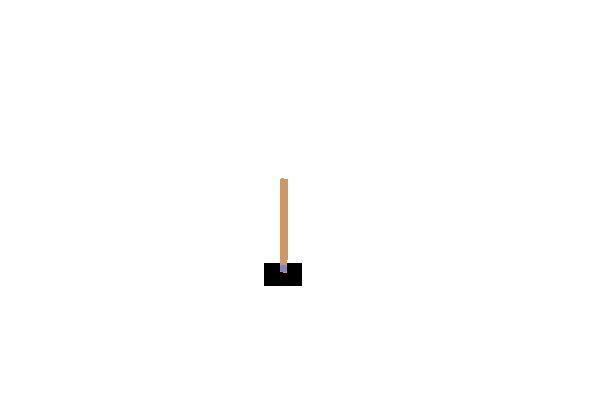
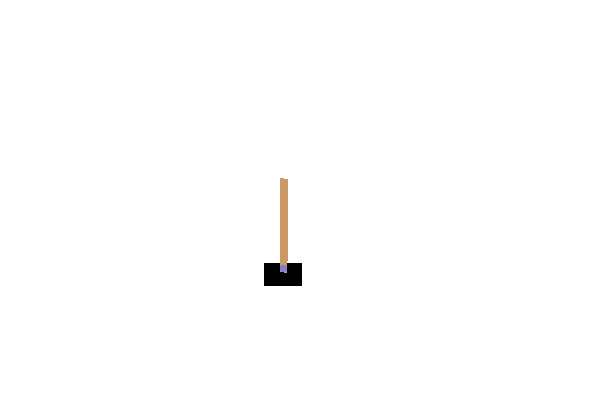
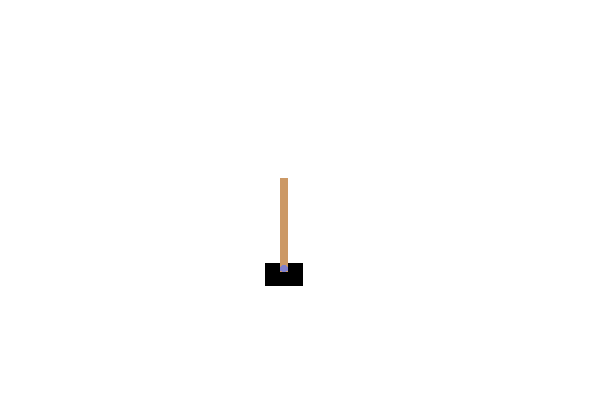
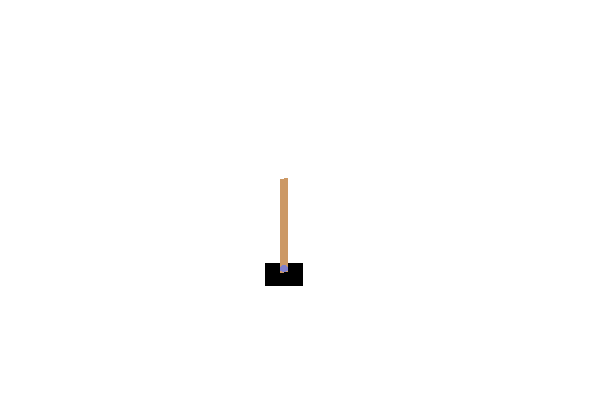
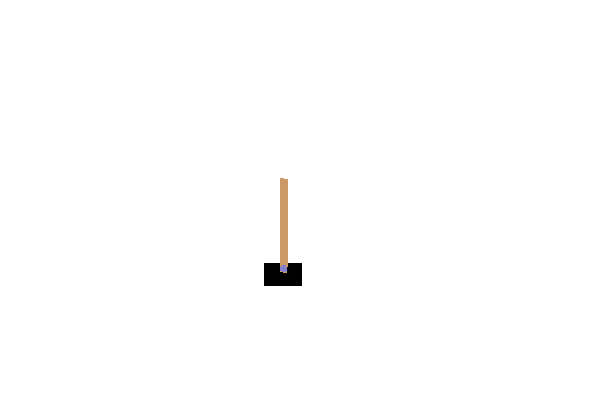
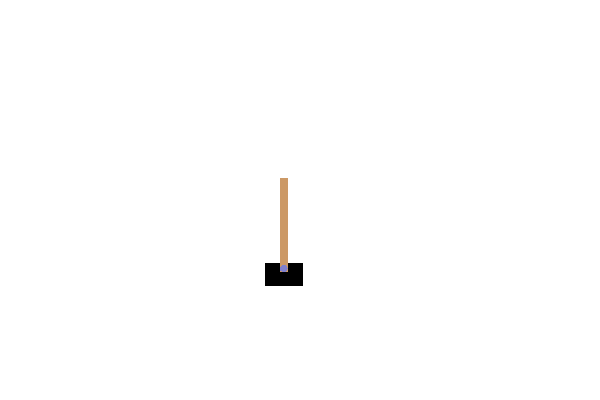
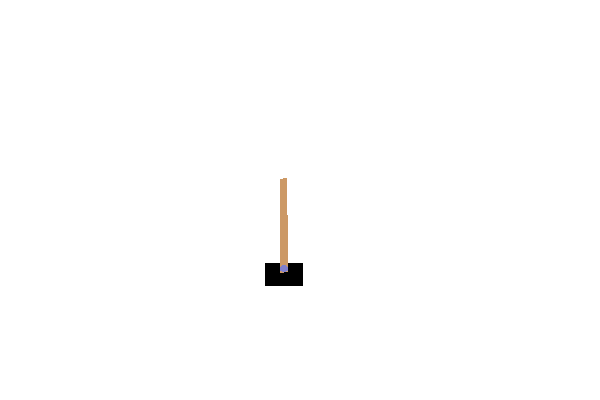
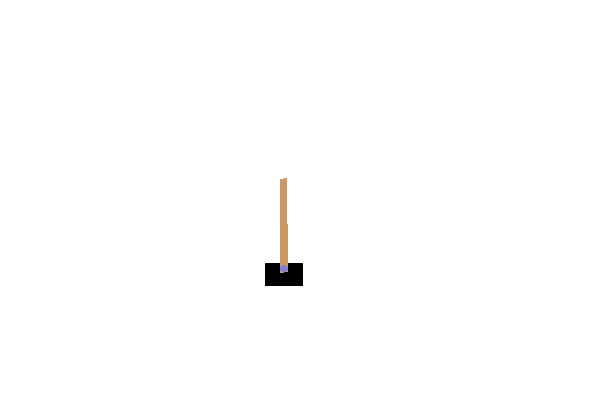
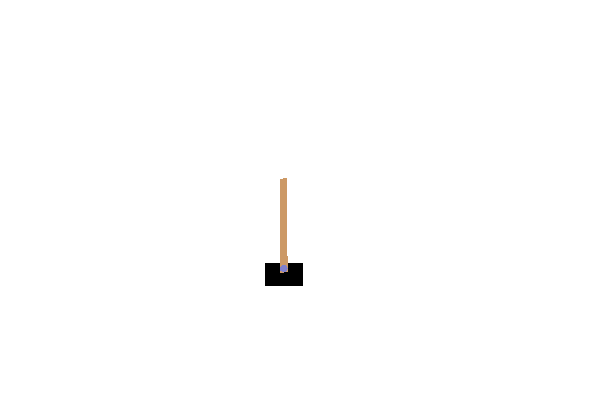
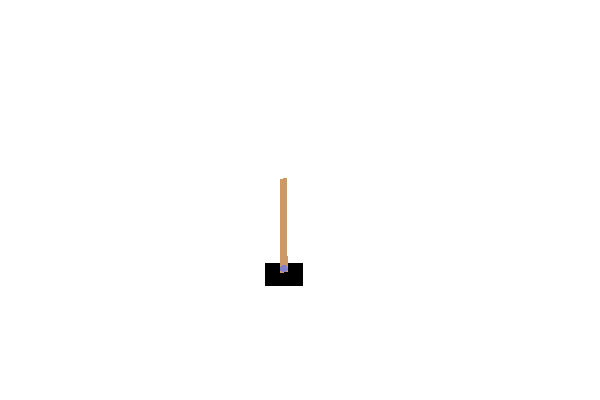
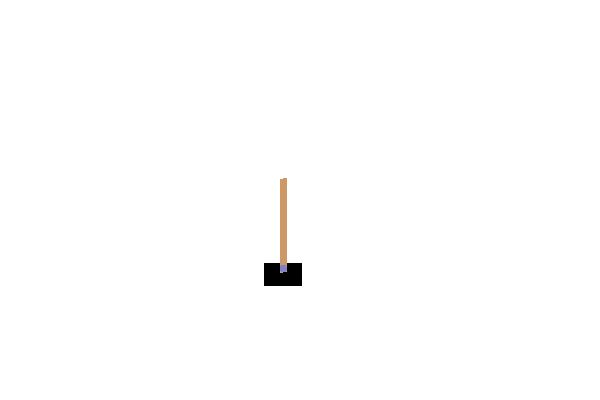
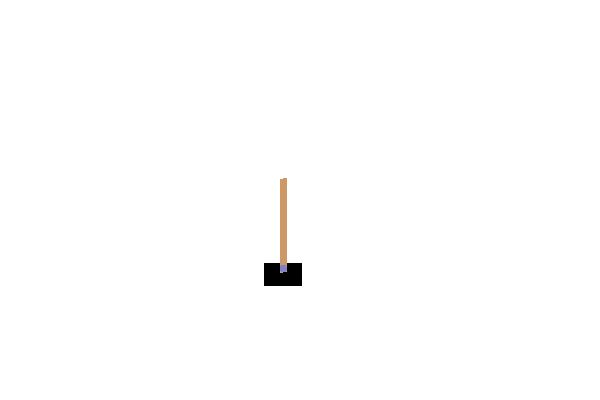
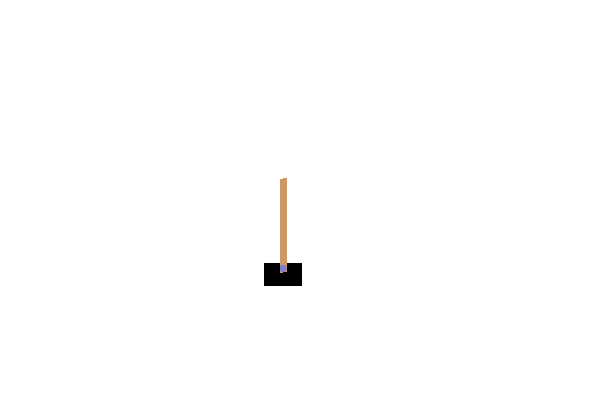
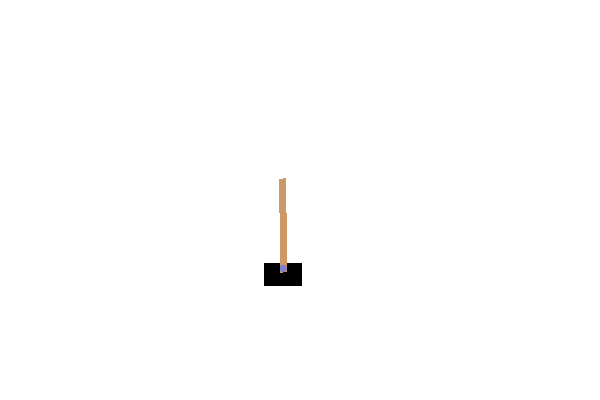

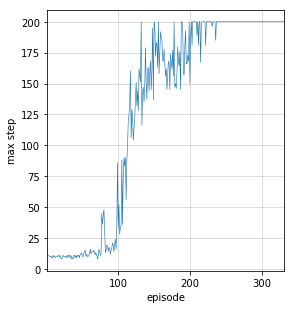

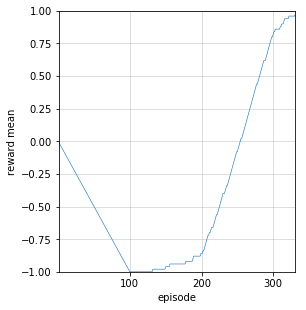

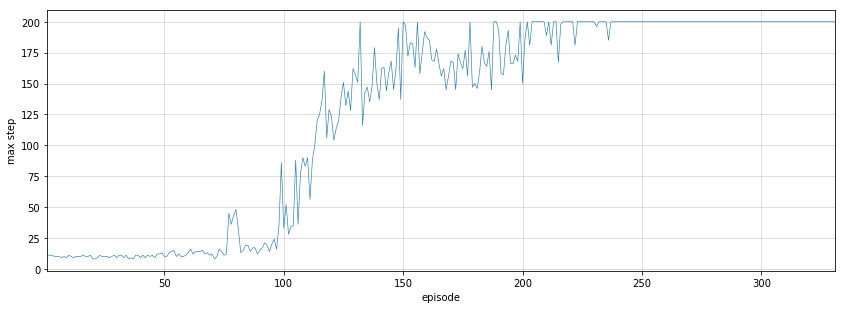

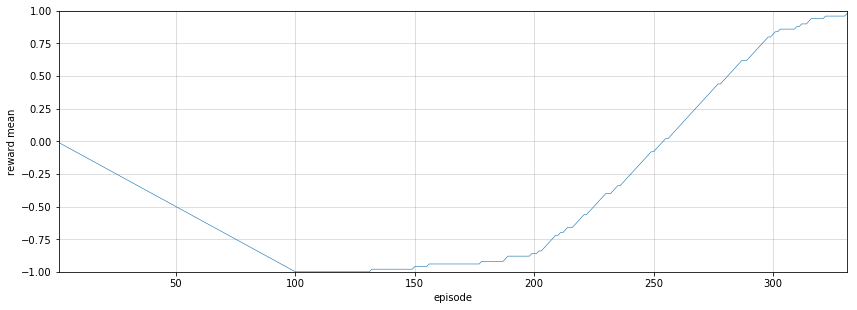

In [9]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()